# Machine Learning Approach to the Spaceship Titanic Kaggle Competition, Comparing Different Models and Data Analysis
 
### Members
Aidan Rabinowitz-2341197-https://www.kaggle.com/aidanrabinowitz

Ledile Seopa-2091153-https://www.kaggle.com/ledileseopa (this Kaggle link contains the submission of the final models from this notebook)


# 1. Introduction

The following notebook explores different approaches to solving the Spaceship Titanic Kaggle problem. Four different engineers approached this problem in four parts: Cleaning up the dataset (filling in empty values and evaluating which columns are important and why); Feature engineering (adding columns based on logically understanding how the data can be expanded, and how columns relate to others in special ways); and applying the data to six different Machine Learning (ML) models, seeing how different approaches to processing and extrapolating the data, affect the accuracy of different ML models. Then, Cross Validation (CV) and Ensembles are applied to the models to assess if accuracy can be improved. Finally, the different models and data processing methods are assessed, in terms of accuracy. The notebook is structured so that

In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
train_df_len = len(train_df)
test_df_len = len(test_df)


input\sample_submission.csv
input\test.csv
input\train.csv


In [75]:
null_count = train_df['CryoSleep'].isnull().sum()
print(null_count)

217


In [76]:
null_count = train_df['HomePlanet'].isnull().sum()
print(null_count)

201


### 1.1. Libraries

Below are some common libraries necessary to run the code, to give an indication of the models used. Most libraries are also added at their point of use, for ease of maneuverability.

In [77]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn as sb
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# 2. Exploratory Data Analysis

Exploratory data analysis (EDA) is performed on the datasat to investigate notable features in the data. This can inform feature engineering, as well as how to fill in missing cells.

### 2.1 Data Description

Analysing the data visually is extremely important for determining the importance of certain features, and assessing how to use and expand upon the given data. The simplest form of this is using the head() function to view the raw data.

In [78]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [79]:
# Different models require different datatypes, usually requiring numerical data, so it is important for data exploration and model choice, to consider the types.
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Different models require different datatypes, usually requiring numerical data, so it is important for data exploration and model choice, to consider the types.


### 2.1.1. Summarized Dataset Features
* PassengerID - in form gggg_pp. gggg represents the group the passenger is travelling in and pp represents the person number within the group
* HomePlanet - Passenger's planet of residence
* CryoSleep - Bool value for if passenger is in cryosleep
* Cabin - which cabin they have booked on the spaceship
* Destination - where the passenger is going
* Age - the age of the passenger
* VIP - Bool value if passenger is a VIP
* RoomService - amount of credits passenger has spent on room service
* FoodCourt - amount of credits passenger has spent at the food court
* ShoppingMall - amount of credits passenger has spent at the mall
* Spa - amount of credits passenger has spent
* VRDeck - amount of credits passenger has spent at VR Deck
* Name - passenger's name
* Transported - If the patient was transported to another dimension. This is the target variable that the model will need to predict.

Potential feature engineering is explored in the below paragraph, through exploring the data: 

The Kaggle website provides some strong hints that the data should be feature engineered. For example, referring to the names and cabin numbers and how families may be inferred from this information. This implies that a Family column, or something similar, like a column depicting the size of each family, by repeats in last names coupled with repeats in room numbers, can be created. Logically, this can relate to the likelihood of being transported, because families often stick together. Other columns are assessed, such as the columns to do with spending money. These may be used to create a "wealth" column. Potentially wealthier passengers will have a higher chance of being transported. However, passengers in cryosleep do not spend any money, and may be wealthy, so this data will not accurately assess all passengers. The exploratory data analysis is inspired in part by the guide on Kaggle title "Spaceship Titanic: A complete guide"[3]. This guide also inspired some aspects of feature engineering that is explored later in the notebook.

The target feature which the models will predict is the 'Transported' feature. This feature shows wether or not a passenger was transported. Firstly the target feature is plot as pie chart to illustrate the distrubtion of passengers that were transported or not.

Text(0.5, 1.0, 'Target distribution')

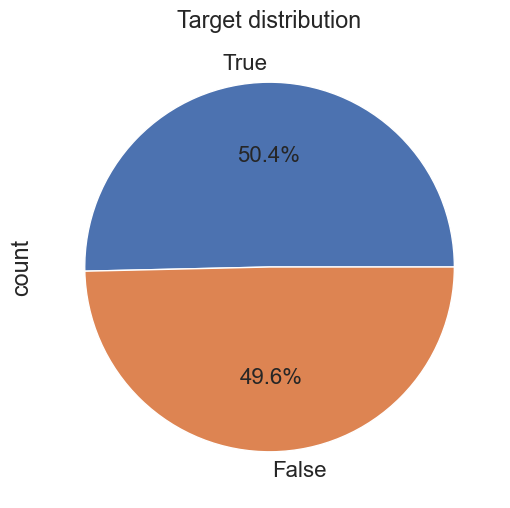

In [80]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
train_df['Transported'].value_counts().plot.pie(autopct='%1.1f%%', shadow=False, textprops={'fontsize':16}).set_title("Target distribution")

The pie shart shows the target is evenly balanced between true and false.

- determining the number of rows in the train data

In [81]:
len(train_df)

8693

- Analysing the descriptive statistics in the data frame to gain better insights on the numeric variables which makes it easier to understand and use the data accordingly

In [82]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


- Looking at categorical and numeric variables of the data frame

In [83]:
def get_categorical_variables(df):
    return df.select_dtypes(include=['object']).columns

def get_numerical_variables(df):
    return df._get_numeric_data().columns

In [84]:
c_var=get_categorical_variables(train_df)
for col in c_var:
    print(col)

PassengerId
HomePlanet
CryoSleep
Cabin
Destination
VIP
Name


In [85]:
n_var=get_numerical_variables(train_df)
for col in n_var:
    print(col)

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
Transported


## 2.2. Exploring the data parameters visually

### Description:
- It is helpful to get an understanding of the data based on how it presents on different graphs. Understanding trends in the data through visual analysis is much easier than simply analysing the many rows of strings and numbers in the raw data [2].




### Rationale: 
- By segmenting the age distribution based on the "Transported" status, the plot allows for comparison between individuals who were transported and those who were not. This segmentation can reveal potential differences in age distribution between the two groups. The question to be asked is, "Are certain age groups more likely to be transported than others?" Then if there is some correlation, adding an Age_Group column, will likely increase the accuracy of a model trained on the data.

Text(0.5, 0, 'Age (years)')

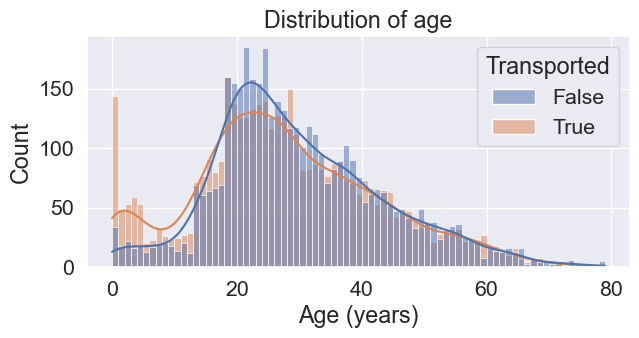

In [86]:
# Figure size
plt.figure(figsize=(7,3))

# Construct Histogram
sns.histplot(data=train_df, x='Age', hue='Transported', binwidth=1, kde=True)

# Plot labels
plt.title('Distribution of age')
plt.xlabel('Age (years)')

### Note: 

There is a correlation between age group and being transported. It appears that younger passengers stand a greater change of being transported, thus this column of age groups can be an important feature to add to a model.

### Rationale:
- The purpose of this visualization is to explore how passengers allocate their credits across different categories of amenities/services on the spaceship, and to examine potential differences in spending behavior between passengers who were transported and those who were not.


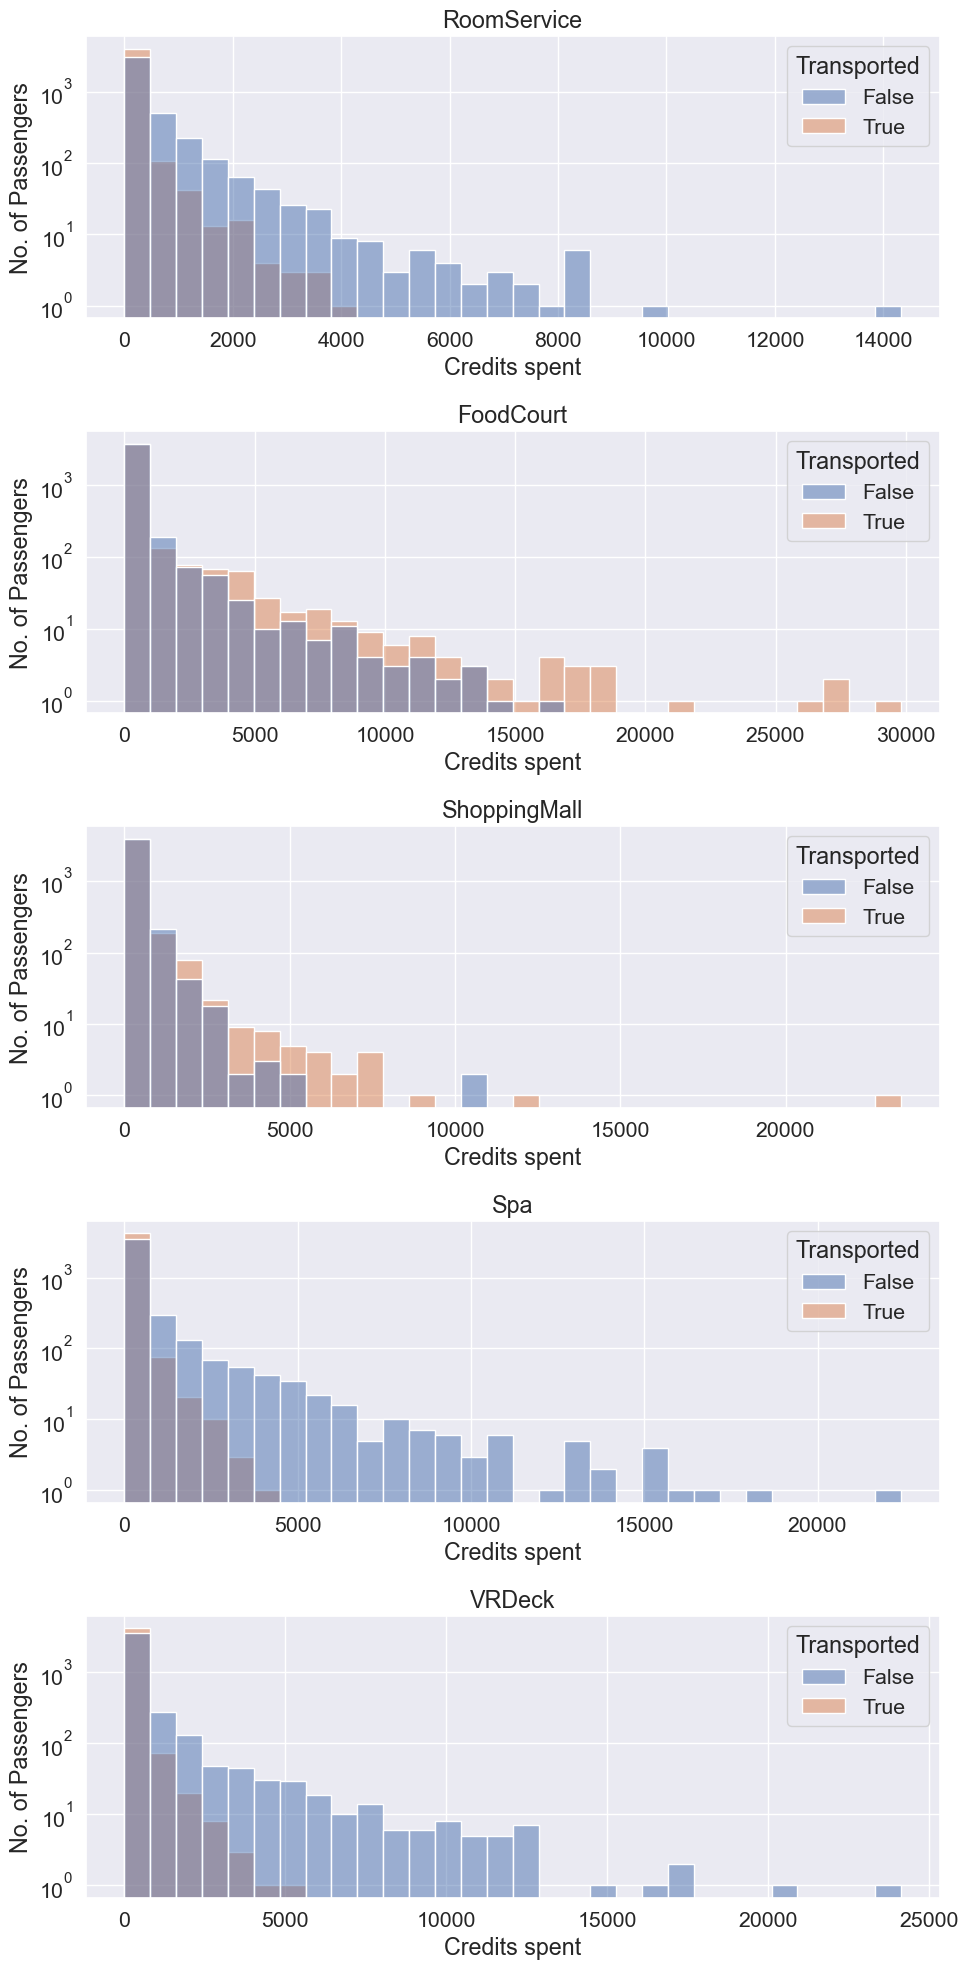

In [87]:
# Credit spending features
total_spent=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(total_spent):
    # Left plot
    ax=fig.add_subplot(5,1,i+1)
    sns.histplot(data=train_df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    ax.set_yscale('log')  # Setting y-axis to logarithmic scale
    ax.set_xlabel("Credits spent")  
    ax.set_ylabel("No. of Passengers")
    
    
fig.tight_layout()  # Improves appearance a bit
plt.show()

### Note: 
* The histograms of FoodCourt and ShoppingMall look different to that of the other spending features.
* If a passenger was spending more credits in foodcourt and shopping mall it can be assumed that they had quicker access to the escape pad and could escape during an evacuation order.
* Passengers spending credits on VRDeck, Spa, and RoomService, were more likely to not be transported. They may have been receiving room service, in the spa or VR deck during an evacuation order and did not respond as quickly.
* If a passenger spent 0 credits for RoomService, Spa and VRDeck, they were more likely to be saved.
* If a passenger spent 0 credits for FoodCourt and ShoppingMall, they were equally likely to be transported as not.


## 2.3. Analysis of Categorical Features: 
The ratio of passengers transported against not transported across various categorical. The expectation is to observe how each categorical feature may influence whether a passenger is transported or not

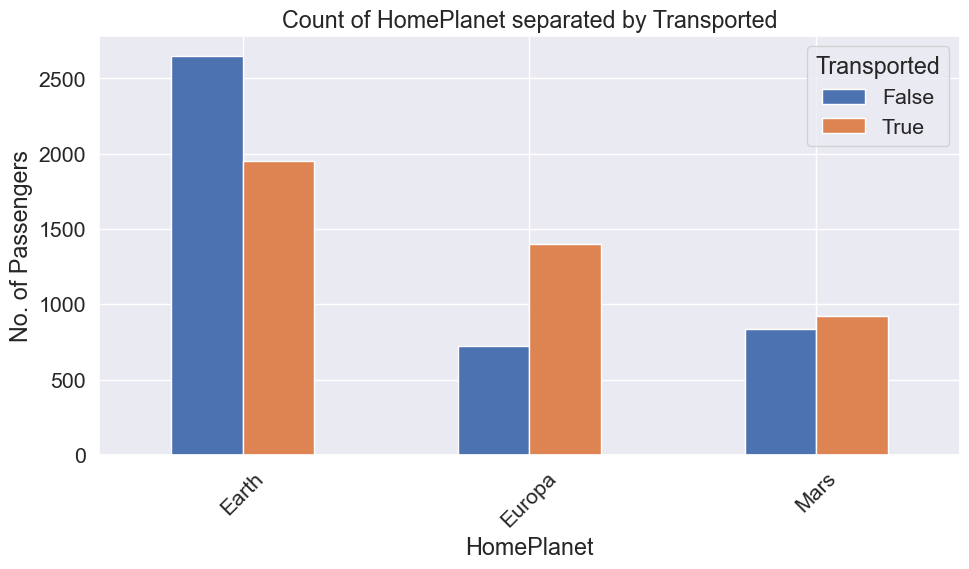

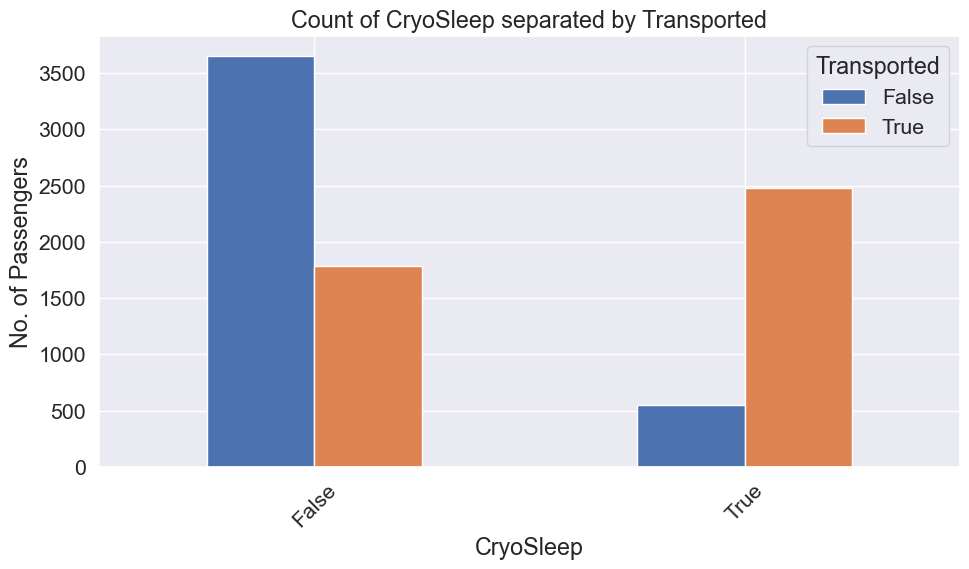

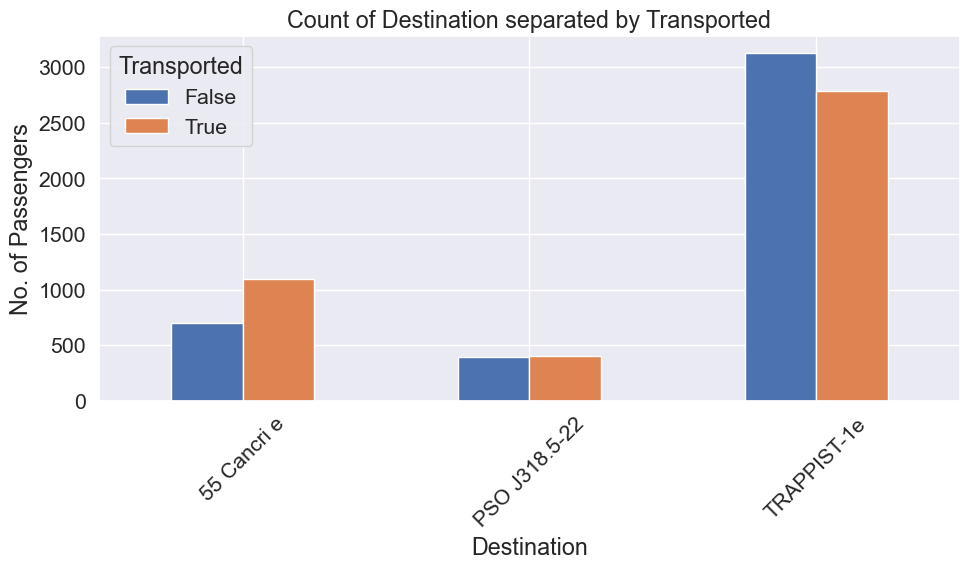

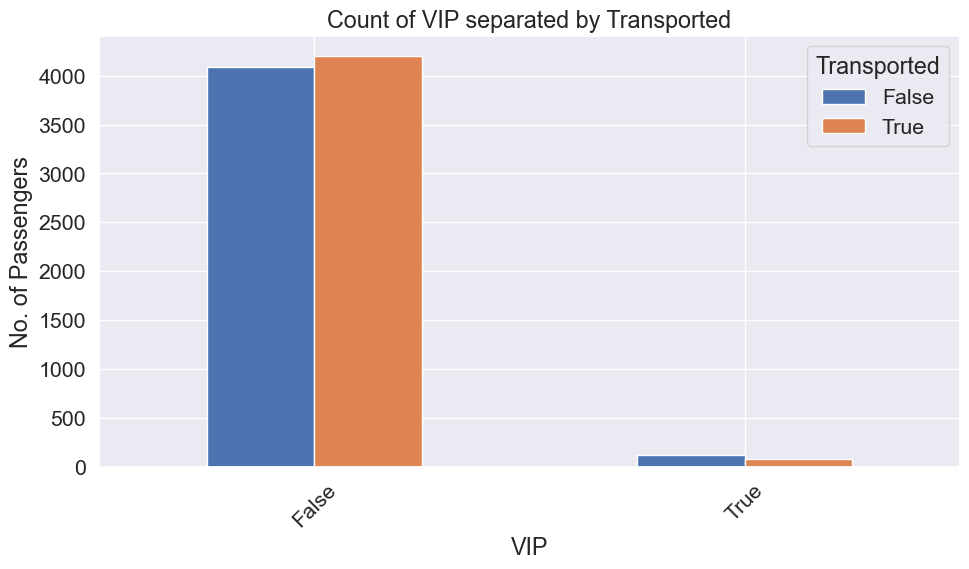

In [88]:
categorial_features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for i, var in enumerate(categorial_features):
    counts = train_df.groupby([var, 'Transported']).size().unstack()
    counts.plot(kind='bar', stacked=False, figsize=(10, 6))
    plt.title('Count of ' + var +' separated by Transported')
    plt.xlabel(var)
    plt.ylabel('No. of Passengers')
    plt.xticks(rotation=45)
    plt.legend(title='Transported')
    plt.tight_layout()
    plt.show()


### Note: 
The plots show for that transported passengers vary across categorical features. Passengers from Earth as their home planet were less likely to be transported contrary to those passengers that come from Europa. Passengers from Mars are more or less equal in probability of being transported. It seems people who opt for Cryosleep were mostly transported compared to the ones who didn't. The plot of the Destination feature shows that passengers traveling to 55 Cancri e were more likely to be transported than not. Passengers traveling to TRAPPEST-1e were less likely to be transported than not. Also, the VIP's on the spaceship are shown to be more likely to have been transported in contrast to non VIP's.

# 2.4. Data Validation and Checks

### 2.4.1 Combining the train data and test data 
- This allows for easy cleaning on the whole dataset at once

In [89]:
# Function to combine train and test dataframes
def combine_df(train_df, test_df):
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    return combined_df
def separate_df(combined_df, train_df_len, test_df_len):
    train_df = combined_df.iloc[:train_df_len]
    test_df = combined_df.iloc[train_df_len:train_df_len + test_df_len]
    return train_df, test_df


In [90]:
full_df = combine_df(train_df, test_df)
full_df_1 = combine_df(train_df, test_df)
full_df_2 = combine_df(train_df, test_df)

##For analysis in of the data
df = combine_df(train_df, test_df)

### 2.4.2. Check for duplicates in the dataset
It is possible that there are errors in the dataset, like duplicated whole rows, which should be checked for and corrected, since they could skew the data.

In [91]:
def print_duplicates_info(df):
    num_duplicates = df.duplicated().sum()
    percentage_duplicates = np.round(100 * num_duplicates / len(df), 1)
    print(f'Duplicates in dataset: {num_duplicates}, ({percentage_duplicates}%)')

print_duplicates_info(full_df)

Duplicates in dataset: 0, (0.0%)


### 2.4.3. Check for null values in the dataset

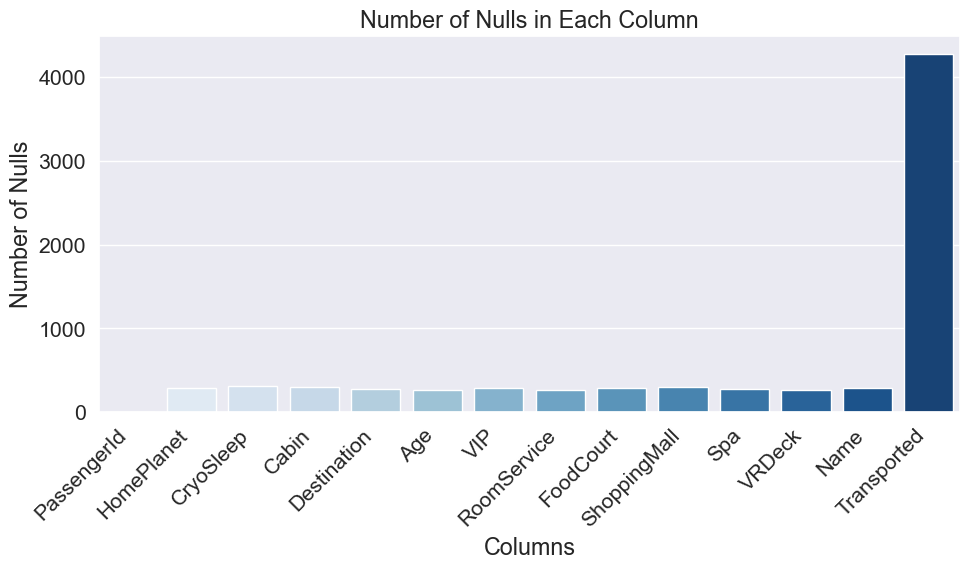

In [92]:
def compute_null_counts(df):
    columns = []
    null_counts = []

    for column in df.columns:
        null_count = df[column].isnull().sum()
        columns.append(column)
        null_counts.append(null_count)

    null_data = pd.DataFrame({'Column': columns, 'Null Count': null_counts})
    return null_data

def plot_null_counts(null_data):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=null_data, x='Column', y='Null Count', palette='Blues')
    plt.xlabel('Columns')
    plt.ylabel('Number of Nulls')
    plt.title('Number of Nulls in Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

null_data = compute_null_counts(full_df)
plot_null_counts(null_data)

Note: To get a clear comparison, transported column is removed 

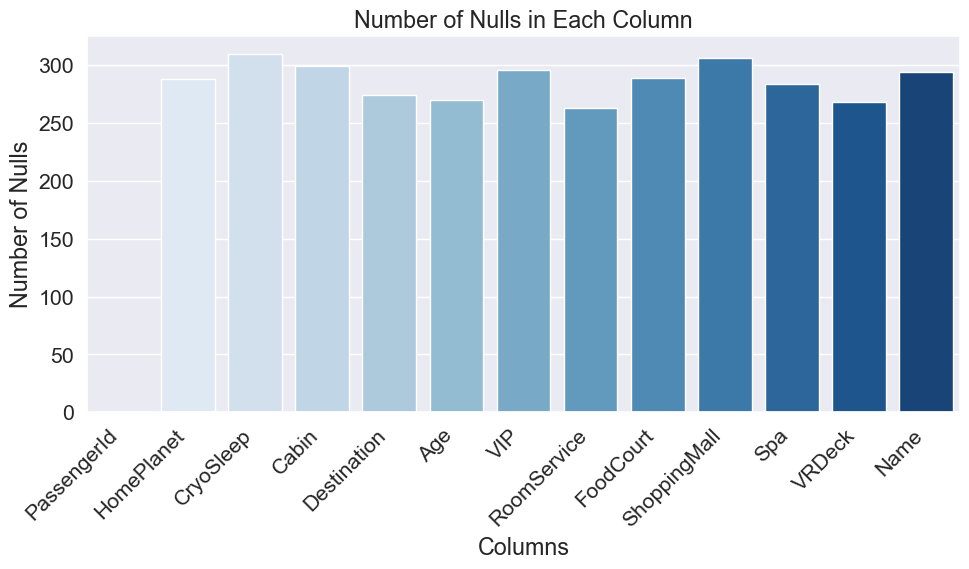

In [93]:
def compute_null_counts_without_transported(df):
    columns = []
    null_counts = []

    for column in df.columns:
        if column != 'Transported':  # Skip the 'Transported' column because we
            null_count = df[column].isnull().sum()
            columns.append(column)
            null_counts.append(null_count)

    null_data = pd.DataFrame({'Column': columns, 'Null Count': null_counts})
    return null_data

null_data_without_transported = compute_null_counts_without_transported(full_df)
plot_null_counts(null_data_without_transported)

### 2.4.4. Looking at the null values in the dataset as a percentage
- Computing the percentages of the null values in the data provides insights to the completeness of the dataset.
- The proportion of missing values to the whole data can affect the overall training of the models. The fewer missing values, the more the dataset can be trusted.

In [94]:
def compute_null_percentages(df):
    total_rows = len(df)
    columns = []
    null_percentages = []

    for column in df.columns:
        if column != 'Transported':
            null_count = df[column].isnull().sum()
            null_percentage = (null_count / total_rows) * 100
            columns.append(column)
            null_percentages.append(null_percentage)

    null_percentage_data = pd.DataFrame({'Column': columns, 'Null Percentage': null_percentages})
    return null_percentage_data

null_percentage_data = compute_null_percentages(full_df)
print(null_percentage_data)

          Column  Null Percentage
0    PassengerId         0.000000
1     HomePlanet         2.220509
2      CryoSleep         2.390131
3          Cabin         2.305320
4    Destination         2.112567
5            Age         2.081727
6            VIP         2.282190
7    RoomService         2.027756
8      FoodCourt         2.228219
9   ShoppingMall         2.359291
10           Spa         2.189668
11        VRDeck         2.066307
12          Name         2.266769


# 3. Data Cleaning and Exploration Analysis

## 3.1. Different approaches on working out Null Values for Different Models

### Rationale:
- Different models achieve different accuracies based on how the data is cleaned.
- The three approaches below show how cleaning of data was considered, by filling in empty data cells and considering outliers.
- Based on numerous tests in this project, specific models used different cleaning approaches which gave higher accuracies

### Creating different data frames on which to peform different cleaning techniques.
Four engineers created four different data frames, but the only applicable differences were found in two datasets, which are attributed to Aidan and Ernest, so these two are tested on the models, along with a control group. The Aidan and Ernest dataframes include specific techniques which were though about logically and tested in their research. This includes considering outliers in age; analysing trends in home planets; using K-Nearest Neighbours (KNN) to fill values, etc. The control dataframe, dfControl, is simply fit to run on models with minimal intervention, i.e. the naN values are filled with the mean values for that column, and any shaping of the data for it to fit certain models is done, e.g. converting categorical or Boolean values to numerical where needed. The KNN filling of the cells was found to significantly lower accuracy, so it has been replaced with the standard mean (numerical imputing) and mode (categorical imputing).

In [95]:
# First, the different datasets are equipped with the raw data. Later they will undergo feature engineering and data cleaning.
dfAidan = full_df 
dfErnest = full_df_1
dfControl = full_df_2

## 3.1. Data Cleaning Approach 1 - Filling empty cells using mean and mode 
The preprocess_data(df) function is used to implement the simple processing of data, without intense analysis of the columns and cells, as seen in the function fill_null_ernest_approach(dfErnest). Interestingly, this simple preprocessing provided a high accuracy when processed on different ML models, even though it required very little effort to implement. This is applied on dfControl and dfAidan.

This function fills null values in categorical variables of a DataFrame with the mode of each column.

### Parameters:
- `df`: DataFrame: The DataFrame containing categorical variables with null values.
- `categorical_variables`: list: List of categorical variable names.
- `numerical_variables`: list: List of numerical variable names.

Categorical data, like string datatypes, and numerical data, like integers, are handled differently by different models, so this function organizes the data into both.


In [96]:
def preprocess_data(df):
    
    # Fill missing values in numerical columns with mean
    numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

    # Fill missing values in categorical columns with mode
    categorical_features = ['Cabin_number', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']
    df[categorical_features] = df[categorical_features].apply(lambda x: x.fillna(x.mode()[0]))

    return df

### 3.1.2. Extracting the Cabin Data
The Cabin column is essentially three points of data, a deck, side and number. This is useful when storing data, but for analysis, it should be expanded so that more details can be observed.

In [97]:
def extract_Cabin_Data(data):
    # Fill NaN's 
    data['Cabin'].fillna('Z/9999/Z', inplace=True)
    
    # Enter in new features
    data['Cabin_deck'] = data['Cabin'].apply(lambda x: x.split('/')[0]).astype(object)
    data['Cabin_number'] = data['Cabin'].apply(lambda x: x.split('/')[1]).astype(float)
    data['Cabin_side'] = data['Cabin'].apply(lambda x: x.split('/')[2]).astype(object)

    # Put Nan's back in (These values will be filled later)
    data.loc[data['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
    data.loc[data['Cabin_number']==9999, 'Cabin_number']=np.nan
    data.loc[data['Cabin_side']=='Z', 'Cabin_side']=np.nan

    # Drop Cabin (we don't need it anymore)
    data.drop('Cabin', axis=1, inplace=True)

    return data

### 3.1.3. Preparing DFControl
The control group has no "special" data cleaning and no feature engineering. The Name column is dropped because logically, someone's name should not affect their changes of surviving, and because it has no feature engineering, the dfControl does not require the name for family size, which is a feature engineering implementation used in this report (families have the same last names, commonly).

In [98]:
dfControl = extract_Cabin_Data(dfControl)
dfControl = preprocess_data(dfControl)
# Drop the 'Name' column
dfControl = dfControl.drop(columns=['Name'])
nan_counts = dfControl.isna().sum()
print(nan_counts)

PassengerId        0
HomePlanet         0
CryoSleep          0
Destination        0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Transported     4277
Cabin_deck         0
Cabin_number       0
Cabin_side         0
dtype: int64


In [99]:
dfAidan = extract_Cabin_Data(dfAidan)
dfAidan = preprocess_data(dfAidan)

## 3.2. Approach 2
This is the most complex approach, which involves a careful and logical analysis of each column, including assessing the likelihood of passengers from particular planets to travel to other planets; making assumptions about spending relating to patients in cryosleep (who logically should not be able to spend on the room service and food court etc. whilst sleeping). The below functions are used to fill null values for the dfErnest, and are encapsulated into one function for ease of use.

- Imputating Null Values in the HomePlanet Column-We are using the relationship between the Destination and the planet
    ##an individual came form

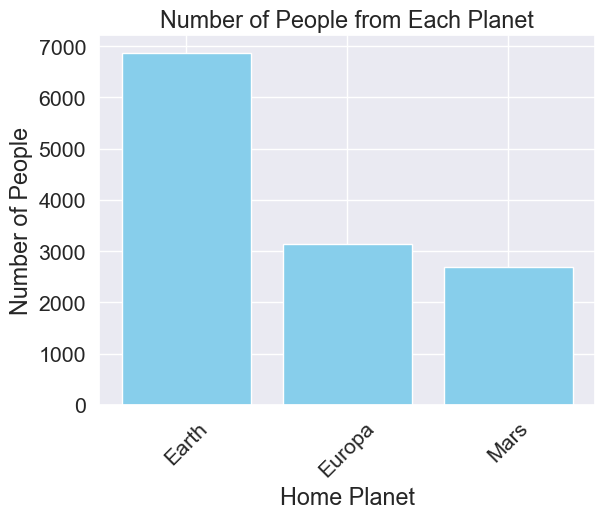

In [100]:
# Create a DataFrame with the count of people from each planet
planet_counts = df['HomePlanet'].value_counts()

# Plotting
plt.bar(planet_counts.index, planet_counts.values, color='skyblue')
plt.title('Number of People from Each Planet')
plt.xlabel('Home Planet')
plt.ylabel('Number of People')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [101]:
    ###To see how many possible destinations we have:

print("Number of unique destinations:", df['Destination'].nunique())


Number of unique destinations: 3


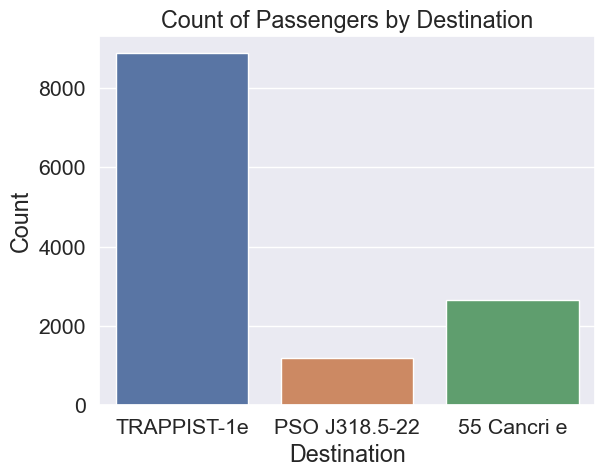

In [102]:
    ### To see the count of people going to each unique Destination

sb.countplot(data=df, x='Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by Destination')
plt.show()

###Note:
-It is clear that more people are going to TRAPPIST-1e, 55 Cancri-e and PSO J318.5-22 respectively

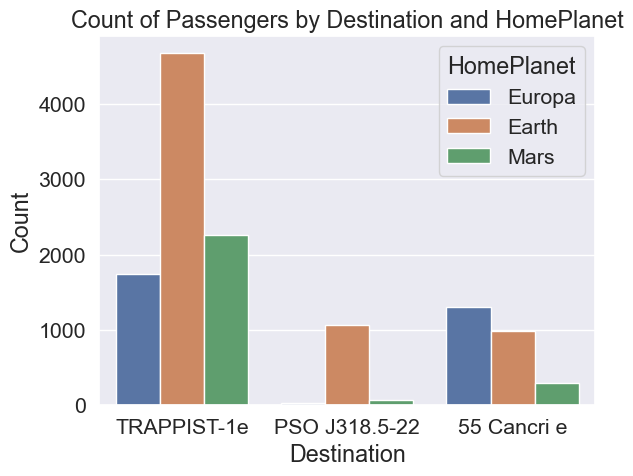

In [103]:
    ###For each destination, how many people from each planet are going there:
    
sb.countplot(data=df, x='Destination', hue='HomePlanet')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by Destination and HomePlanet')
plt.legend(title='HomePlanet')
plt.show()

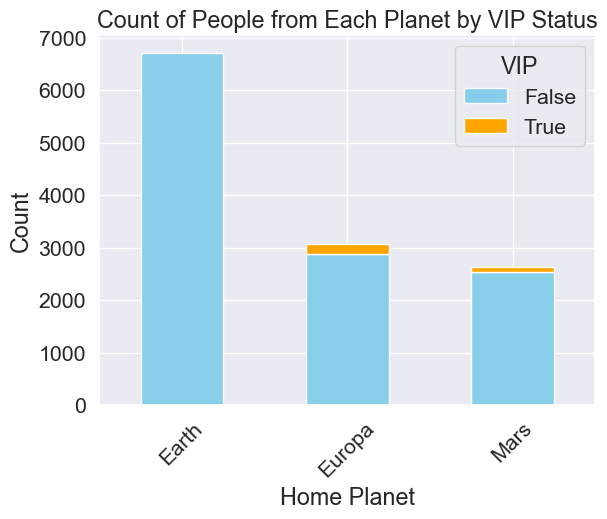

In [104]:
    ###How many people from each planet are VIP or not:
    
    # Group by both HomePlanet and VIP, then count the occurrences
planet_vip_counts = df.groupby(['HomePlanet', 'VIP']).size().unstack(fill_value=0)

# Plotting
planet_vip_counts.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Count of People from Each Planet by VIP Status')
plt.xlabel('Home Planet')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='VIP')
plt.show()

In [105]:
###Age distribution of People from each Planet:

grouped = df.groupby('HomePlanet')['Age']

# Calculate quartiles
quartiles = grouped.describe(percentiles=[0.25, 0.5, 0.75])

# Print quartiles in words
for planet, data in quartiles.iterrows():
    print(f"HomePlanet: {planet}")
    print(f"25th Percentile (Q1): {data['25%']:.2f} years")
    print(f"Median (Q2): {data['50%']:.2f} years")
    print(f"75th Percentile (Q3): {data['75%']:.2f} years")
    print("")


HomePlanet: Earth
25th Percentile (Q1): 18.00 years
Median (Q2): 23.00 years
75th Percentile (Q3): 34.00 years

HomePlanet: Europa
25th Percentile (Q1): 26.00 years
Median (Q2): 33.00 years
75th Percentile (Q3): 42.00 years

HomePlanet: Mars
25th Percentile (Q1): 20.00 years
Median (Q2): 28.00 years
75th Percentile (Q3): 38.00 years



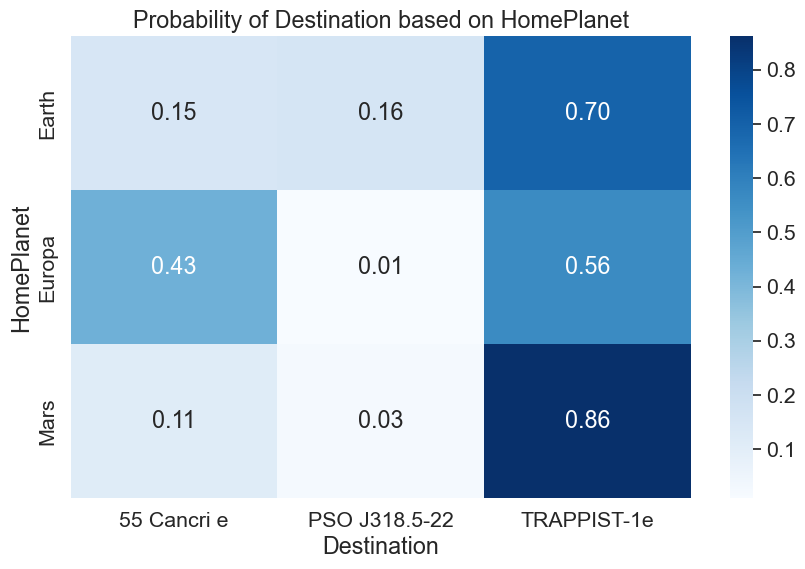

In [106]:
    ###This probability distribution should still stand even after the imputation!!!

# Count occurrences of each combination of HomePlanet and Destination
counts = df.groupby(['HomePlanet', 'Destination']).size().unstack(fill_value=0)

# Normalize the counts to get probabilities
probabilities = counts.div(counts.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sb.heatmap(probabilities, annot=True, cmap='Blues', fmt=".2f", cbar=True)
plt.title('Probability of Destination based on HomePlanet')
plt.xlabel('Destination')
plt.ylabel('HomePlanet')
plt.show()

In [107]:
    ### Check the number of null values in the HomePlanet column
null_count = df['HomePlanet'].isnull().sum()
print("Number of null values in HomePlanet column:", null_count)

Number of null values in HomePlanet column: 288


In [108]:
def fill_null_homeplanet(df):
    for index, row in df.iterrows():
        if pd.isnull(row['HomePlanet']):
            if row['Destination'] == 'TRAPPIS-1e' and row['VIP']:
                age = row['Age']
                if age < 26:
                    df.at[index, 'HomePlanet'] = 'Europa'
                else:
                    df.at[index, 'HomePlanet'] = 'Mars'
            elif row['Destination'] == 'PSO J318.5-22':
                df.at[index, 'HomePlanet'] = 'Earth'
            elif row['Destination'] == '55 Cancri e' and not row['VIP']:
                df.at[index, 'HomePlanet'] = 'Earth'
            elif row['Destination'] == '55 Cancri e' and row['VIP']:
                df.at[index, 'HomePlanet'] = 'Europa'
            else:
                df.at[index, 'HomePlanet'] = 'Earth'
    return df

- Imputation of Null Values in the CryoSleep Column:


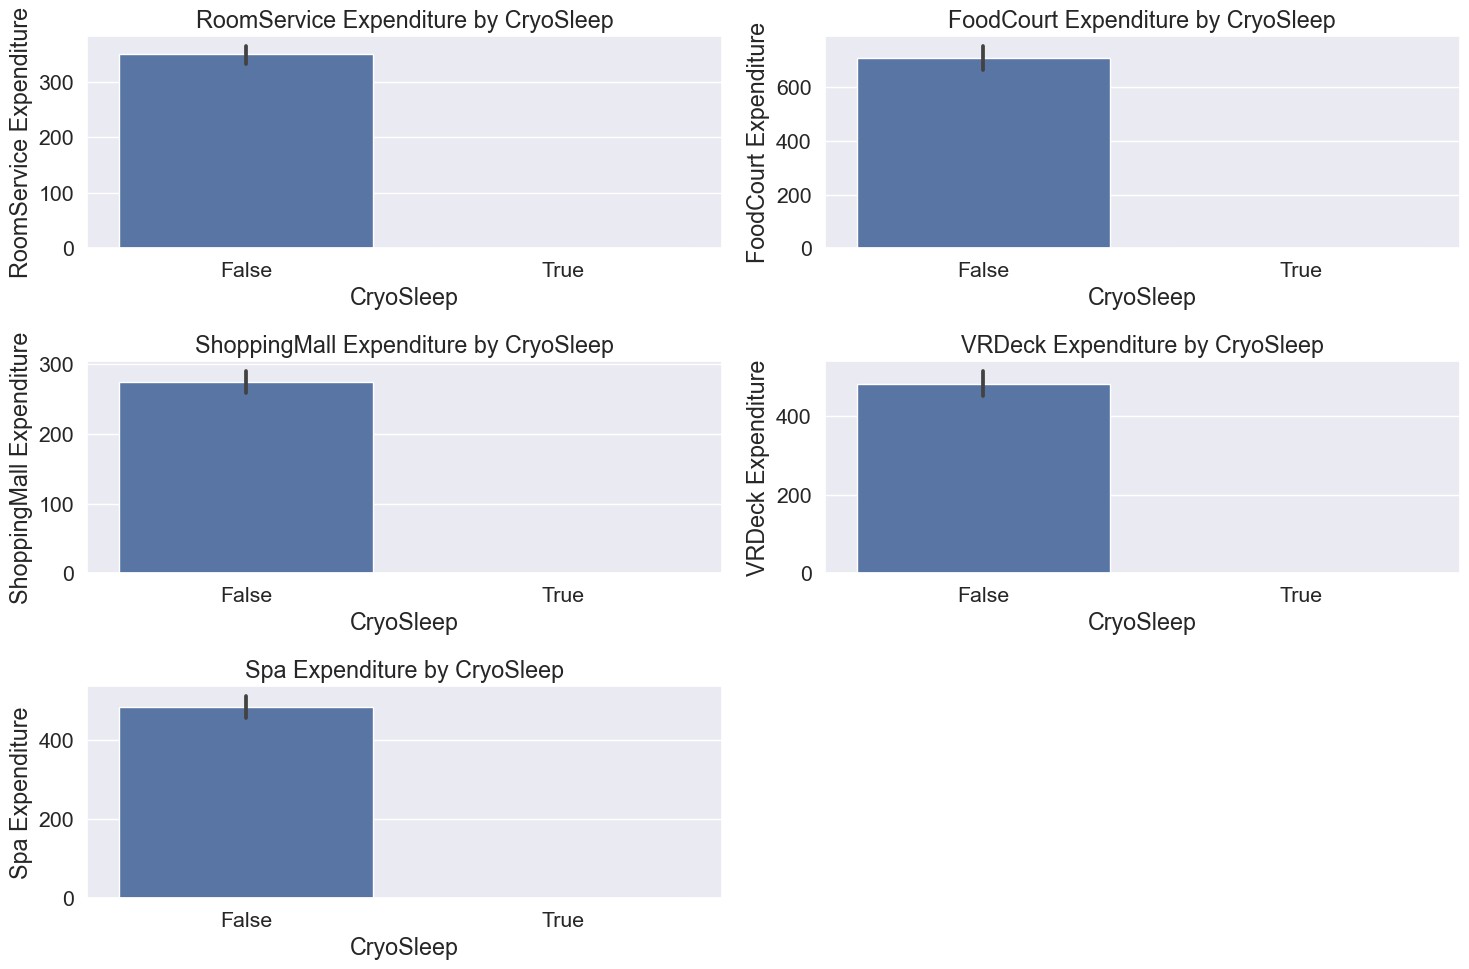

In [109]:
###Relate the CryoSleep with Expenditures

# List of columns
columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck', 'Spa']

# Plotting
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns):
    plt.subplot(3, 2, i+1)  # Adjusted indexing
    sb.barplot(x='CryoSleep', y=col, data=df)
    plt.title(f'{col} Expenditure by CryoSleep')
    plt.xlabel('CryoSleep')
    plt.ylabel(f'{col} Expenditure')
plt.tight_layout()
plt.show()


### Note:
- #We see that When CryoSleep is True, all expenditures are Zero:

In [110]:
# Fill null values in CryoSleep based on the sum of expenditures
def fill_null_cryosleep(df):
    df['CryoSleep'] = df['CryoSleep'].fillna((df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['VRDeck']) == 0)
    return df

- Imputation of Null values for the Cabin Number:

In [111]:
nulls_in_name = df['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

Number of null values in the Cabin column: 299


In [112]:
nulls_in_name = df['Name'].isnull().sum()
print("Number of null values in the Name column:", nulls_in_name)

Number of null values in the Name column: 294


In [113]:
# Count the number of null values in Cabin corresponding to null values in Name
null_cabin_null_name_count = df[df['Cabin'].isnull() & df['Name'].isnull()].shape[0]

print("Number of null values in Cabin corresponding to null values in Name:", null_cabin_null_name_count)


Number of null values in Cabin corresponding to null values in Name: 3


In [114]:
# Initialize a counter for group numbers with no other rows having a non-null Cabin number
count_unique_group_numbers = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in df[df['Cabin'].isnull()].iterrows():
    # Extract group number from PassengerId
    group_number = row['PassengerId'].split('_')[0]
    
    # Check if there are other rows with the same group number and a non-null Cabin number
    if df[(df['PassengerId'].str.split('_').str[0] == group_number) & (~df['Cabin'].isnull())].empty:
        count_unique_group_numbers += 1

print("Number of group numbers with no other rows having a non-null Cabin number:", count_unique_group_numbers)

Number of group numbers with no other rows having a non-null Cabin number: 162


In [116]:
# Initialize a counter for unique last names with no other rows having a non-null Cabin number
count_unique_last_names = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in df[df['Cabin'].isnull()].iterrows():
    # Check if the 'Name' value is not NaN
    if not pd.isnull(row['Name']):
        # Extract the last name from the Name column
        last_name = row['Name'].split()[-1]
        
        # Check if there are other rows with the same last name and a non-null Cabin number
        if df[(df['Name'].str.split().str[-1] == last_name) & (~df['Cabin'].isnull())].empty:
            # If no such rows exist, fill the NaN value in the 'Cabin' column with a specific value
            df.loc[index, 'Cabin'] = 'Unknown'


print("Number of unique last names with no other rows having a non-null Cabin number:", count_unique_last_names)


Number of unique last names with no other rows having a non-null Cabin number: 0


### Rationale:
- This code iterates over each row with a null value in the Cabin column, 
extracts the last name from the corresponding Name column,
finds other rows with the same last name and a non-null Cabin number, and
fills in the null value in the Cabin column with the found Cabin number.

In [119]:
# Iterate over each row with a null value in the Cabin number column
for index, row in df[df['Cabin'].isnull()].iterrows():
    # Check if the 'Name' value is not NaN
    if not pd.isnull(row['Name']):
        # Extract the last name from the Name column
        last_name = row['Name'].split()[-1]
        
        # Find other rows with the same last name and a non-null Cabin number
        matching_rows = df[(df['Name'].str.split().str[-1] == last_name) & (~df['Cabin'].isnull())]
        
        # Check if there are any matching rows
        if not matching_rows.empty:
            # Get the Cabin number from the first matching row
            cabin_number = matching_rows.iloc[0]['Cabin']
            
            # Fill in the null value in the Cabin column with the found Cabin number
            df.at[index, 'Cabin'] = cabin_number
        else:
            # If no matching rows are found, fill the 'Cabin' value with a placeholder
            df.at[index, 'Cabin'] = 'Unknown'


In [120]:
nulls_in_name = df['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

Number of null values in the Cabin column: 3


In [121]:
# Iterate over each row with a null value in the Name column
for index, row in df[df['Name'].isnull()].iterrows():
    # Extract the Cabin number from the corresponding Cabin column
    cabin_number = row['Cabin']
    
    # Find other rows with the same Cabin number and a non-null Name
    matching_rows = df[(df['Cabin'] == cabin_number) & (~df['Name'].isnull())]
    
    # Check if there are any matching rows
    if not matching_rows.empty:
        # Get the first matching row
        matching_row = matching_rows.iloc[0]
        
        # Extract the last name from the non-null Name value
        last_name = matching_row['Name'].split()[-1]
        
        # Fill in the null value in the Name column with the generated name
        df.at[index, 'Name'] = "Firstname A " + last_name


In [122]:
nulls_in_name = df['Name'].isnull().sum()
print("Number of null values in the Name column:", nulls_in_name)

Number of null values in the Name column: 184


In [123]:
# Initialize a counter for unique last names with no other rows having a non-null Cabin number
count_unique_last_names = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in df[df['Cabin'].isnull()].iterrows():
    # Extract the last name from the Name column
    last_name = row['Name'].split()[-1]
    
    # Check if there are other rows with the same last name and a non-null Cabin number
    if df[(df['Name'].str.split().str[-1] == last_name) & (~df['Cabin'].isnull())].empty:
        count_unique_last_names += 1

print("Number of unique last names with no other rows having a non-null Cabin number:", count_unique_last_names)

AttributeError: 'float' object has no attribute 'split'

In [124]:

# Initialize a counter for group numbers with no other rows having a non-null Cabin number
count_unique_group_numbers = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in df[df['Cabin'].isnull()].iterrows():
    # Extract group number from PassengerId
    group_number = row['PassengerId'].split('_')[0]
    
    # Check if there are other rows with the same group number and a non-null Cabin number
    if df[(df['PassengerId'].str.split('_').str[0] == group_number) & (~df['Cabin'].isnull())].empty:
        count_unique_group_numbers += 1

print("Number of group numbers with no other rows having a non-null Cabin number:", count_unique_group_numbers)

Number of group numbers with no other rows having a non-null Cabin number: 1


In [125]:
# Iterate over each row with a null value in the Name column
for index, row in df[df['Name'].isnull()].iterrows():
    # Extract the group number (gggg) from the corresponding PassengerId column
    group_number = row['PassengerId'].split('_')[0]
    
    # Find other rows with the same group number and a non-null Name
    matching_rows = df[(df['PassengerId'].str.split('_').str[0] == group_number) & (~df['Name'].isnull())]
    
    # Check if there are any matching rows
    if not matching_rows.empty:
        # Get the first matching row
        matching_row = matching_rows.iloc[0]
        
        # Extract the last name from the non-null Name value
        last_name = matching_row['Name'].split()[-1]
        
        # Fill in the null value in the Name column with the generated name
        df.at[index, 'Name'] = "Firstname A " + last_name


In [126]:
# Iterate over each row with a null value in the Cabin column
for index, row in df[df['Cabin'].isnull()].iterrows():
    # Print the PassengerId and Name for the current row
    print("PassengerId:", row['PassengerId'], "Name:", row['Name'])

PassengerId: 6141_02 Name: Firstname A Haydenzier
PassengerId: 8366_02 Name: Firstname A Burnewman
PassengerId: 3367_01 Name: nan


In [127]:
def fill_null_cabin_by_group(df):
    # Extract group numbers from PassengerId for rows with null Cabin values
    null_cabin_groups = df[df['Cabin'].isnull()]['PassengerId'].str.split('_').str[0]
    
    # Iterate over each null Cabin row
    for index, row in df[df['Cabin'].isnull()].iterrows():
        # Get the group number for the current row
        group_number = row['PassengerId'].split('_')[0]
        
        # Find other rows with the same group number and non-null Cabin values
        similar_group_rows = df[(df['PassengerId'].str.split('_').str[0] == group_number) & (~df['Cabin'].isnull())]
        
        # If there are similar group rows, fill the null Cabin value with the first non-null Cabin value
        if not similar_group_rows.empty:
            df.at[index, 'Cabin'] = similar_group_rows.iloc[0]['Cabin']
    
    return df

In [128]:
def fill_null_cabin_by_name(df):
    # Iterate over each row with a null value in the Cabin number column
    for index, row in df[df['Cabin'].isnull()].iterrows():
        # Check if the 'Name' column is not null
        if not pd.isnull(row['Name']):
            # Extract the last name from the Name column
            last_name = row['Name'].split()[-1]
        
        # Find other rows with the same last name and a non-null Cabin number
        matching_rows = df[(df['Name'].str.split().str[-1] == last_name) & (~df['Cabin'].isnull())]
        
        # Check if there are any matching rows
        if not matching_rows.empty:
            # Get the Cabin number from the first matching row
            cabin_number = matching_rows.iloc[0]['Cabin']
            
            # Fill in the null value in the Cabin column with the found Cabin number
            df.at[index, 'Cabin'] = cabin_number
    return df

In [129]:
def fill_null_cabin_by_mode(df):
    # Calculate the mode of the 'Cabin' column
    mode_cabin = df['Cabin'].mode().iloc[0]

    # Fill null values in the 'Cabin' column with the mode
    df['Cabin'].fillna(mode_cabin, inplace=True)
    return df

In [130]:
# Define a function to predict the VIP status based on expenditure and HomePlanet
def predict_vip(row):
    if row['VRDeck'] > row['Spa']:
        return True
    elif row['Spa'] > row['VRDeck']:
        return False
    else:
        if row['HomePlanet'] == 'Earth':
            return False
        elif row['HomePlanet'] == 'Europa':
            return True
        elif row['HomePlanet'] == 'Mars':
            return True  # If HomePlanet is Mars, VIP should be True
        else:
            return None  # Return None for other cases

- VIP null Imputation:

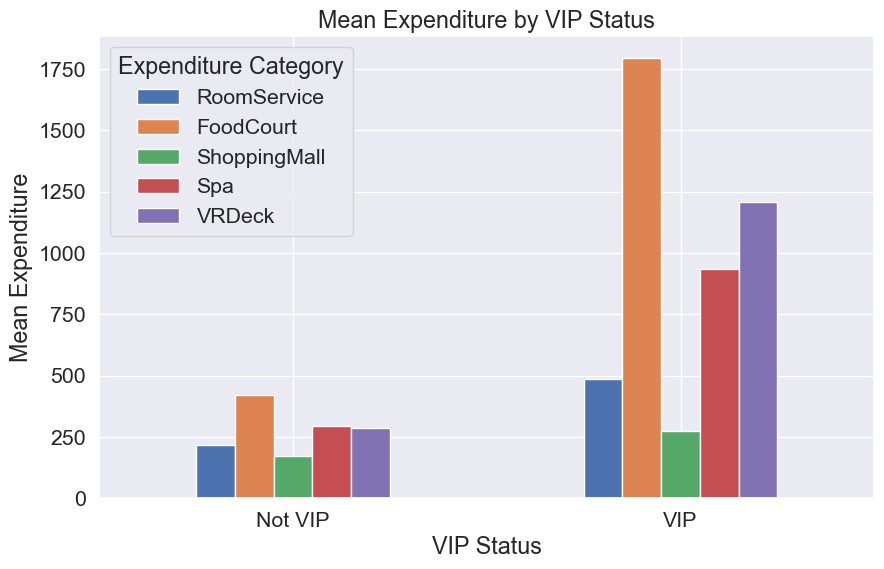

In [131]:
# Group by VIP and calculate the mean expenditure for each category
expenditure_means = df.groupby('VIP')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()

# Plot the bar graph
expenditure_means.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Expenditure by VIP Status')
plt.xlabel('VIP Status')
plt.ylabel('Mean Expenditure')
plt.xticks(ticks=[0, 1], labels=['Not VIP', 'VIP'], rotation=0)
plt.legend(title='Expenditure Category')
plt.show()

In [132]:
def fill_null_vip(df):
    # Apply the function to rows with null values in the VIP column
    df.loc[df['VIP'].isnull(), 'VIP'] = df[df['VIP'].isnull()].apply(predict_vip, axis=1)
    return df

- Imputating null values from the Destination column

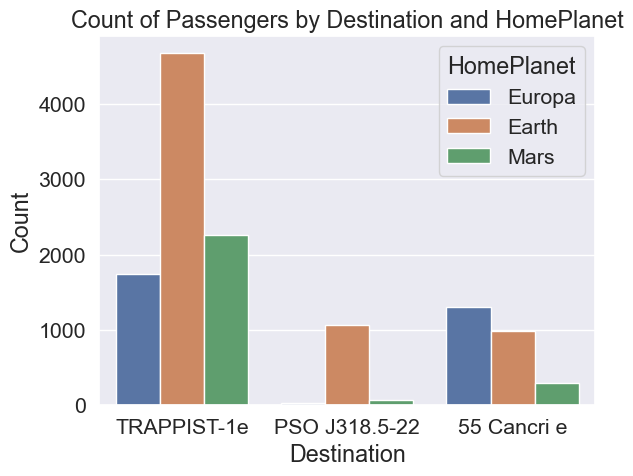

In [133]:
    ###For each destination, how many people from each planet are going there:
    
sb.countplot(data=df, x='Destination', hue='HomePlanet')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by Destination and HomePlanet')
plt.legend(title='HomePlanet')
plt.show()



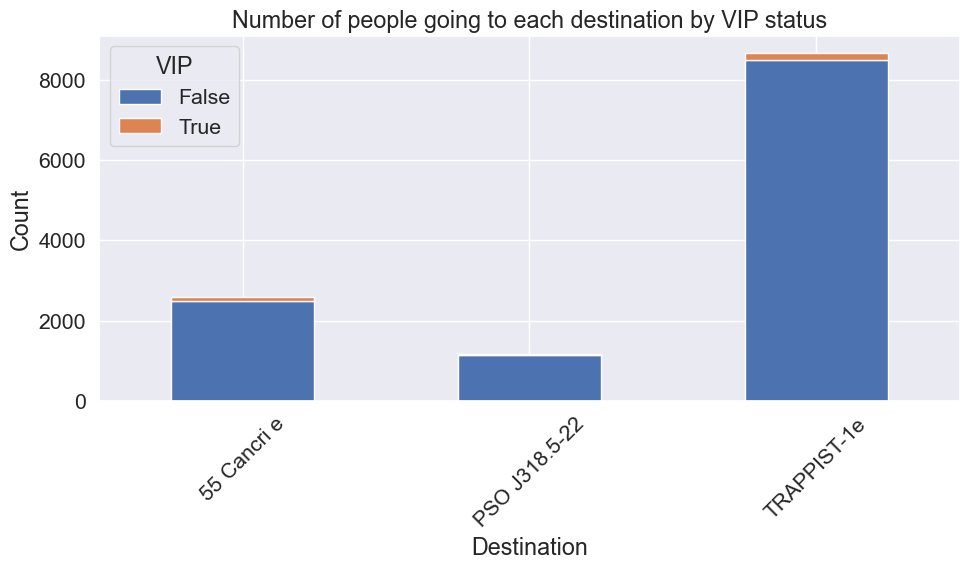

In [134]:

# Group data by Destination and VIP
destination_vip_counts = df.groupby(['Destination', 'VIP']).size().unstack(fill_value=0)

# Plot the data
destination_vip_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Number of people going to each destination by VIP status')

# Show the plot
plt.legend(title='VIP')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [135]:
def fill_null_destination_by_homeplanet(df): 
    # Fill null values in Destination based on HomePlanet and VIP status
    df.loc[(df['HomePlanet'] == 'Earth') & (df['VIP'] == False) & (df['Destination'].isnull()), 'Destination'] = 'PSO J318.5-22'
    df.loc[(df['HomePlanet'] == 'Earth') & (df['VIP'] == True) & (df['Destination'].isnull()), 'Destination'] = 'TRAPPIST-1e'
    df.loc[(df['HomePlanet'] == 'Europa') & (df['VIP'] == False) & (df['Destination'].isnull()), 'Destination'] = '55 Cancri e'
    df.loc[(df['HomePlanet'] == 'Europa') & (df['VIP'] == True) & (df['Destination'].isnull()), 'Destination'] = 'TRAPPIST-1e'
    df.loc[(df['HomePlanet'] == 'Mars') & (df['VIP'] == False) & (df['Destination'].isnull()), 'Destination'] = '55 Cancri e'
    df.loc[(df['HomePlanet'] == 'Mars') & (df['VIP'] == True) & (df['Destination'].isnull()), 'Destination'] = 'TRAPPIST-1e'
    return df

- Imputation of null values for the Age:

In [136]:
###Age distribution of People from each Planet:

grouped = df.groupby('HomePlanet')['Age']

# Calculate quartiles
quartiles = grouped.describe(percentiles=[0.25, 0.5, 0.75])

# Print quartiles in words
for planet, data in quartiles.iterrows():
    print(f"HomePlanet: {planet}")
    print(f"25th Percentile (Q1): {data['25%']:.2f} years")
    print(f"Median (Q2): {data['50%']:.2f} years")
    print(f"75th Percentile (Q3): {data['75%']:.2f} years")
    print("")

HomePlanet: Earth
25th Percentile (Q1): 18.00 years
Median (Q2): 23.00 years
75th Percentile (Q3): 34.00 years

HomePlanet: Europa
25th Percentile (Q1): 26.00 years
Median (Q2): 33.00 years
75th Percentile (Q3): 42.00 years

HomePlanet: Mars
25th Percentile (Q1): 20.00 years
Median (Q2): 28.00 years
75th Percentile (Q3): 38.00 years



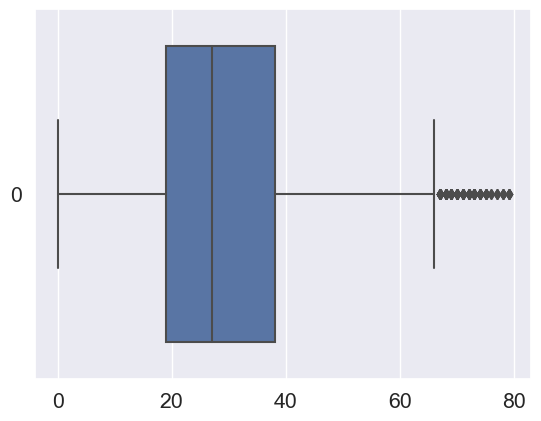

In [137]:
#Imputing 'Age' null values, but first consider outliers

sb.boxplot(df['Age'],orient='h')
plt.show()

In [138]:
def fill_null_age(df):
    # Impute null values in Age column where Spa expenditure is 0 with 6
    df.loc[(df['Age'].isnull()) & (df['Spa'] == 0), 'Age'] = 6   
    #get mean for age below 61
    temp = df[df['Age'] < 61]['Age'].mean()
    df['Age'] = df['Age'].fillna(temp) 
    return df

dfErnest = fill_null_age(dfErnest)

In [139]:
def calculate_outlier_bounds(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound


- Imputating null values For FoodCourt

In [140]:
## Calculate summary statistics for FoodCourt expenditure for VIP and non-VIP individuals
vip_foodcourt_stats = df[df['VIP'] == True]['FoodCourt'].describe()
non_vip_foodcourt_stats = df[df['VIP'] == False]['FoodCourt'].describe()

# Display the summary statistics
print("Summary statistics for FoodCourt expenditure among VIP individuals:")
print(vip_foodcourt_stats)
print("\nSummary statistics for FoodCourt expenditure among non-VIP individuals:")
print(non_vip_foodcourt_stats)

Summary statistics for FoodCourt expenditure among VIP individuals:
count      267.000000
mean      1793.651685
std       3593.931435
min          0.000000
25%          0.000000
50%        280.000000
75%       2167.500000
max      29813.000000
Name: FoodCourt, dtype: float64

Summary statistics for FoodCourt expenditure among non-VIP individuals:
count    12123.000000
mean       419.522808
std       1465.779835
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      27071.000000
Name: FoodCourt, dtype: float64


In [141]:
def fill_null_foodcourt(df):
    lower_bound, upper_bound = calculate_outlier_bounds(df['FoodCourt'])
    df_cleaned = df[(df['FoodCourt'] >= lower_bound) & (df['FoodCourt'] <= upper_bound)]

    # Calculate mean and median based on VIP status
    mean_vip = df_cleaned[df_cleaned['VIP'] == True]['FoodCourt'].mean()
    median_vip = df_cleaned[df_cleaned['VIP'] == True]['FoodCourt'].median()

    mean_non_vip = df_cleaned[df_cleaned['VIP'] == False]['FoodCourt'].mean()
    median_non_vip = df_cleaned[df_cleaned['VIP'] == False]['FoodCourt'].median()

    # Fill null values based on mean and median
    df.loc[(df['VIP'] == True) & (df['FoodCourt'].isnull()), 'FoodCourt'] = mean_vip
    df.loc[(df['VIP'] == False) & (df['FoodCourt'].isnull()), 'FoodCourt'] = mean_non_vip
    return df

- Imputating null values For ShoppingMall:

In [142]:
## Summary statistics for ShoppingMall expenditure among VIP individuals
vip_shopping_stats = df[df['VIP'] == True]['ShoppingMall'].describe()
print("Summary statistics for ShoppingMall expenditure among VIP individuals:")
print(vip_shopping_stats)
print()

# Summary statistics for ShoppingMall expenditure among non-VIP individuals
non_vip_shopping_stats = df[df['VIP'] == False]['ShoppingMall'].describe()
print("Summary statistics for ShoppingMall expenditure among non-VIP individuals:")
print(non_vip_shopping_stats)


Summary statistics for ShoppingMall expenditure among VIP individuals:
count     266.000000
mean      273.680451
std       575.222273
min         0.000000
25%         0.000000
50%         0.000000
75%       277.250000
max      3700.000000
Name: ShoppingMall, dtype: float64

Summary statistics for ShoppingMall expenditure among non-VIP individuals:
count    12107.000000
mean       174.006608
std        595.481307
min          0.000000
25%          0.000000
50%          0.000000
75%         26.000000
max      23492.000000
Name: ShoppingMall, dtype: float64


In [143]:
def fill_null_shoppingmall(df):
    lower_bound, upper_bound = calculate_outlier_bounds(df['ShoppingMall'])
    df_cleaned = df[(df['ShoppingMall'] >= lower_bound) & (df['ShoppingMall'] <= upper_bound)]

    # Calculate mean and median based on VIP status
    mean_vip = df_cleaned[df_cleaned['VIP'] == True]['ShoppingMall'].mean()
    median_vip = df_cleaned[df_cleaned['VIP'] == True]['ShoppingMall'].median()

    mean_non_vip = df_cleaned[df_cleaned['VIP'] == False]['ShoppingMall'].mean()
    median_non_vip = df_cleaned[df_cleaned['VIP'] == False]['ShoppingMall'].median()

    # Fill null values based on mean and median
    df.loc[(df['VIP'] == True) & (df['ShoppingMall'].isnull()), 'ShoppingMall'] = mean_vip
    df.loc[(df['VIP'] == False) & (df['ShoppingMall'].isnull()), 'ShoppingMall'] = mean_non_vip
    return df

- Imputating null values for Spa column

In [144]:
def fill_null_spa(df):
    # Removing outliers from the 'Spa' column using the Interquartile Range (IQR) method
    lower_bound, upper_bound = calculate_outlier_bounds(df['Spa'])

    # Filter out rows with Spa expenditure outside the IQR range
    filtered_df = df[(df['Spa'] >= lower_bound) & (df['Spa'] <= upper_bound)]

    # Calculate mean and median of Spa expenditures for VIP and non-VIP individuals
    mean_spa_vip = filtered_df[filtered_df['VIP'] == True]['Spa'].mean()
    median_spa_vip = filtered_df[filtered_df['VIP'] == True]['Spa'].median()
    mean_spa_non_vip = filtered_df[filtered_df['VIP'] == False]['Spa'].mean()
    median_spa_non_vip = filtered_df[filtered_df['VIP'] == False]['Spa'].median()

    # Fill null values in the 'Spa' column based on VIP status
    df.loc[(df['VIP'] == True) & (df['Spa'].isnull()), 'Spa'] = mean_spa_vip
    df.loc[(df['VIP'] == False) & (df['Spa'].isnull()), 'Spa'] = mean_spa_non_vip
    return df

- Imputating null values for VRDECK column:

In [145]:

def fill_null_vrdeck(df):
    lower_bound, upper_bound = calculate_outlier_bounds(df['VRDeck'])

    # Filter out rows with VRDeck expenditure outside the IQR range
    filtered_df = df[(df['VRDeck'] >= lower_bound) & (df['VRDeck'] <= upper_bound)]

    # Calculate mean and median of VRDeck expenditures for VIP and non-VIP individuals
    mean_vrdeck_vip = filtered_df[filtered_df['VIP'] == True]['VRDeck'].mean()
    median_vrdeck_vip = filtered_df[filtered_df['VIP'] == True]['VRDeck'].median()
    mean_vrdeck_non_vip = filtered_df[filtered_df['VIP'] == False]['VRDeck'].mean()
    median_vrdeck_non_vip = filtered_df[filtered_df['VIP'] == False]['VRDeck'].median()

    # Fill null values in the 'VRDeck' column based on VIP status
    df.loc[(df['VIP'] == True) & (df['VRDeck'].isnull()), 'VRDeck'] = mean_vrdeck_vip
    df.loc[(df['VIP'] == False) & (df['VRDeck'].isnull()), 'VRDeck'] = mean_vrdeck_non_vip
    return df

- Imputing null values for RoomService column:

In [146]:
## Calculate summary statistics for RoomService expenditure for VIP and non-VIP individuals
vip_roomservice_stats = df[df['VIP'] == True]['RoomService'].describe()
non_vip_roomservice_stats = df[df['VIP'] == False]['RoomService'].describe()

# Display the summary statistics
print("Summary statistics for RoomService expenditure among VIP individuals:")
print(vip_roomservice_stats)
print("\nSummary statistics for RoomService expenditure among non-VIP individuals:")
print(non_vip_roomservice_stats)

Summary statistics for RoomService expenditure among VIP individuals:
count     269.000000
mean      486.349442
std      1058.272031
min         0.000000
25%         0.000000
50%         1.000000
75%       600.000000
max      8243.000000
Name: RoomService, dtype: float64

Summary statistics for RoomService expenditure among non-VIP individuals:
count    12149.000000
mean       216.735698
std        630.845068
min          0.000000
25%          0.000000
50%          0.000000
75%         45.000000
max      14327.000000
Name: RoomService, dtype: float64


In [147]:
def fill_null_roomservice(df):
    lower_bound, upper_bound = calculate_outlier_bounds(df['RoomService'])
    df_cleaned = df[(df['RoomService'] >= lower_bound) & (df['RoomService'] <= upper_bound)]

    # Calculate mean and median based on VIP status
    mean_vip = df_cleaned[df_cleaned['VIP'] == True]['RoomService'].mean()
    median_vip = df_cleaned[df_cleaned['VIP'] == True]['RoomService'].median()

    mean_non_vip = df_cleaned[df_cleaned['VIP'] == False]['RoomService'].mean()
    median_non_vip = df_cleaned[df_cleaned['VIP'] == False]['RoomService'].median()

    # Fill null values based on mean and median
    df.loc[(df['VIP'] == True) & (df['RoomService'].isnull()), 'RoomService'] = mean_vip
    df.loc[(df['VIP'] == False) & (df['RoomService'].isnull()), 'RoomService'] = mean_non_vip
    return df

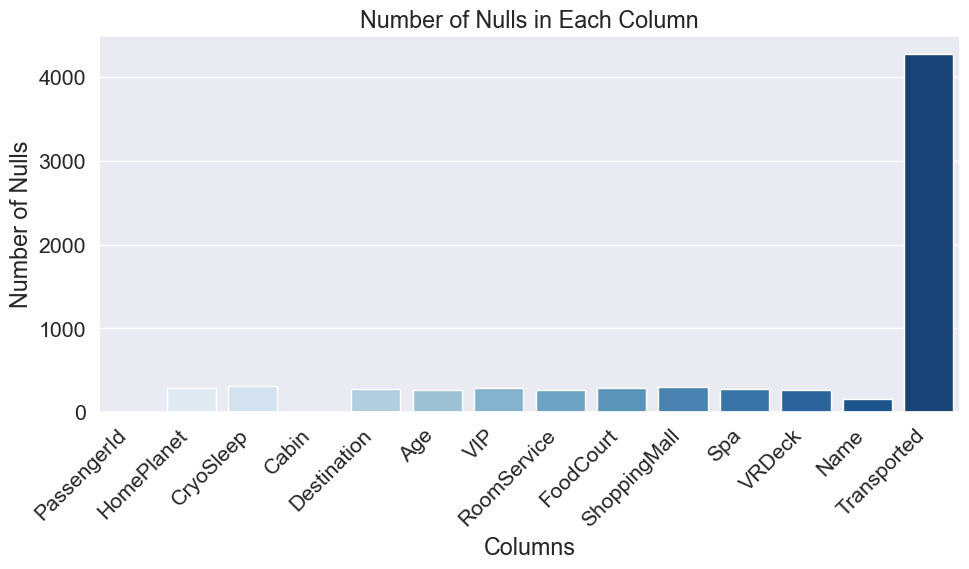

In [148]:
# Create empty lists to store column names and null counts
columns = []
null_counts = []

# Iterate over each column and append the column name and null count to the lists
for column in df.columns:
    null_count = df[column].isnull().sum()
    columns.append(column)
    null_counts.append(null_count)

# Create a DataFrame from the lists
null_data = pd.DataFrame({'Column': columns, 'Null Count': null_counts})

# Plotting
plt.figure(figsize=(10, 6))
sb.barplot(data=null_data, x='Column', y='Null Count', palette='Blues')
plt.xlabel('Columns')
plt.ylabel('Number of Nulls')
plt.title('Number of Nulls in Each Column')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

### Note:
- The null values in the name column doesnt need to be filled becauese it deosnt make senese to assume someone's name, but also the identity doesnt really matter as much to the outcomes.

The function below encapsulates the complexity of the second approach to data cleaning and analysis, to fill null values.

In [149]:
def fill_null_ernest_approach(df):
    df = fill_null_homeplanet(df)
    df = fill_null_cryosleep(df)
    df = fill_null_cabin_by_group(df)
    df = fill_null_cabin_by_name(df)
    df = fill_null_cabin_by_mode(df)
    df = fill_null_vip(df)
    df = fill_null_destination_by_homeplanet(df)
    df = fill_null_age(df)
    df = fill_null_foodcourt(df)
    df = fill_null_shoppingmall(df)
    df = fill_null_spa(df)
    df = fill_null_vrdeck(df)
    df = fill_null_roomservice(df)
    return df

In [150]:
dfErnest = fill_null_ernest_approach(dfErnest)

# 4. Feature Engineering
Two feature engineering approaches are encapsulated in feature_engineering_Aidan() and feature_engineering_Ernest(), which contrast in complexity to the Aidan and Ernest approaches to data cleaning and filling in naN values.

## 4.1. Defining Functions for Feature Engineering

### 4.1.1. Explanation of `extract_Group_Data` Function

This function `extract_Group_Data` is designed to extract information related to groups from the input data. Let's break down what it does:

1. **New Feature - Group**: It creates a new feature named 'Group' based on the 'PassengerId' column. For each 'PassengerId', it extracts the part before the underscore ('_') using the `split('_')[0]` function. Then, it converts the extracted string into a float data type using `astype(float)`.

2. **New Feature - Group size**: It creates another new feature named 'Group_size'. For each 'Group', it calculates the size of the group by counting the occurrences of each group and mapping it back to the original data. This is achieved by using a lambda function with the `map` function along with `pd.concat` and `value_counts`.

3. **Return Data**: The function returns the modified data with the added 'Group' and 'Group_size' features.

In summary, this function helps in extracting group-related information from the input data, such as group identification and group size, and adds it as additional features to the dataset.


In [151]:
def extract_Group_Data(data):
    # New feature - Group
    data['Group'] = data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(float)

    # New feature - Group size
    data['Group_size']=data['Group'].map(lambda x: pd.concat([data['Group'], data['Group']]).value_counts()[x])
    
    return data

### 4.1.2. Explanation of `calculate_family_size_Aidan` Function

This function `calculate_family_size_Aidan` aims to calculate the family size for each passenger in the input DataFrame `df`. Let's dissect what each part of the function does:

1. **Extracting First Name and Last Name**: It splits the 'Name' column of the DataFrame into 'FirstName' and 'LastName' columns using the `str.split` method with `expand=True`. This allows the function to separate the first and last names of the passengers.

2. **Grouping by Last Name and Cabin Number**: It groups the DataFrame by 'LastName' and 'Cabin_number', and then applies the `transform('count')` function to count the number of occurrences of each combination of 'LastName' and 'Cabin_number'. This effectively calculates the size of each family based on their shared last name and cabin number.

3. **Assigning Family Size**: It assigns the calculated family size to a new column named 'FamilySize' in the DataFrame.

4. **Returning Modified DataFrame**: Finally, the function returns the modified DataFrame with the additional 'FamilySize' column.

In summary, this function calculates the family size for each passenger based on their shared last name and cabin number, and adds this information as a new feature in the DataFrame.


In [152]:
def calculate_family_size_Aidan(df):
    df[['FirstName', 'LastName']] = df['Name'].str.split(expand=True)
    
    family_counts = df.groupby(['LastName', 'Cabin_number'])['LastName'].transform('count')
    df['FamilySize'] = family_counts
    
    return df

### 4.1.3. Explanation of `create_interaction_features_Aidan` Function

This function `create_interaction_features_Aidan` is responsible for creating interaction features based on certain attributes in the input DataFrame `df`. Below is a breakdown of its operations:

1. **Age Group**: It creates a new feature called 'Age_Group' by categorizing passengers into different age groups. This is achieved using the `pd.cut` function, which bins the 'Age' column into predefined age ranges and assigns corresponding labels such as 'Child', 'Young Adult', 'MiddleAge', etc.

2. **Family Count**: It calculates the count of family members for each passenger based on shared 'LastName' and 'Cabin_number'. This is done by grouping the DataFrame by 'LastName' and 'Cabin_number', and then applying the `transform('count')` function to count the number of occurrences of each combination.

3. **Adding New Features**: It adds the newly created features ('Age_Group' and 'FamilyCount') to the DataFrame.

4. **Returning Modified DataFrame**: Finally, the function returns the DataFrame with the added interaction features.

In summary, this function enhances the input DataFrame by creating interaction features based on age groups and family counts, providing additional insights into the dataset.


In [153]:
# Creating interaction features and adding more features
def create_interaction_features_Aidan(df):
    # Age group
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 15, 30, 45, 60, 75, 90, 105], labels=['Child', 'Young Adult', 'MiddleAge', 'Adult', 'OldAdult', 'Elderly', 'Oldest'])

    # Count of family members (assuming 'LastName' and 'Room_Number' are available)
    df['FamilyCount'] = df.groupby(['LastName', 'Cabin_number'])['PassengerId'].transform('count')

    return df

In [157]:
# Encapsulation of the feature engineering for Aidan's approach
def feature_engineering_Aidan(df):
    df = extract_Group_Data(df)
    df = calculate_family_size_Aidan(df)
    df = create_interaction_features_Aidan(df)
    return df

In [158]:
# Feature Engineering Functions for the Ernest approach
def feature_engineering_Ernest(df):
    df = extract_Group_Data(df)
    return df

In [159]:
dfAidan = feature_engineering_Aidan(dfAidan)
# Dealing with specific column data engineering for dfAidan
mean_family_size = dfAidan['FamilySize'].mean()
mean_family_count = dfAidan['FamilyCount'].mean()
dfAidan['FamilySize'].fillna(mean_family_size, inplace=True)
dfAidan['FamilyCount'].fillna(mean_family_count, inplace=True)

In [160]:
dfErnest = feature_engineering_Ernest(dfErnest)

In [161]:
train_dfControl, test_dfControl = separate_df(dfControl, len(train_df), len(test_df))
train_dfAidan, test_dfAidan = separate_df(dfAidan, len(train_df), len(test_df))
train_dfErnest, test_dfErnest = separate_df(dfErnest, len(train_df), len(test_df))

# 5. Models

The code below is used to firstly impute data based on its datatype, to convert strings, Booleans and categories, into numeric data which can be run on an ML model.

### 5.1. Imputing

In [162]:
def FeatureAndTarget(df):
    #For training data:
    for col in df.columns:
        # In case of categorical column with CategoricalDtype
        if pd.api.types.is_categorical_dtype(df[col].dtype):
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
        # In case of categorical column with object dtype
        elif df[col].dtype == object:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
        # In case of boolean data type 
        elif df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
    
    # Split the data into features (X) and target (Y)
    X = df.drop(columns=['Transported'])
    Y = df['Transported']
    
    return X, Y

In [163]:
XControl, YControl = FeatureAndTarget(train_dfControl)
XAidan, YAidan = FeatureAndTarget(train_dfAidan)
XErnest, YErnest = FeatureAndTarget(train_dfErnest)


### 5.2. Running the Models

The functionality below runs all the models and takes in a training dataframe X and testing dataframe y[5].

In [164]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def preprocess_and_model(X,y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models
    forest_model = RandomForestClassifier(criterion='gini', n_estimators=70, max_depth=5, min_samples_split=2, min_samples_leaf=2,
                                          max_features='sqrt', random_state=42)
    gb_model = GradientBoostingClassifier(random_state=42)
    logreg_model = LogisticRegression(random_state=42)
    knn_model = KNeighborsClassifier()
    nb_model = GaussianNB()
    linear_svc_model = LinearSVC(random_state=42)
    lgbm_model = LGBMClassifier(random_state=42)
    catboost_model = CatBoostClassifier(random_state=42, verbose=False)

    models = [forest_model, gb_model, logreg_model, knn_model, nb_model, linear_svc_model, lgbm_model, catboost_model]
    model_names = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'KNN', 'Naive Bayes', 'Linear SVC', 'LGBM', 'CatBoost']
    
    accuracies = {}
    
    for model, name in zip(models, model_names):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies[name] = accuracy
    
    return accuracies


### 5.2.1. Printing the Accuracy Scores

In [165]:
# Call the function with dfControl as the dataframe
accuracies_control = preprocess_and_model(XControl, YControl)

# Print accuracies
for model, accuracy in accuracies_control.items():
    print(f"{model} Accuracy: {accuracy}")

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
Random Forest Accuracy: 0.7768832662449684
Gradient Boosting Accuracy: 0.7912593444508338
Logistic Regression Accuracy: 0.7602070155261644
KNN Accuracy: 0.7360552041403106
Naive Bayes Accuracy: 0.7113283496262219
Linear SVC Accuracy: 0.6078205865439908
LGBM Accuracy: 0.8016101207590569
CatBoost Accuracy: 0.8090856814261069


In [166]:
# Call the function with dfControl as the dataframe
accuracies_aidan = preprocess_and_model(XAidan, YAidan)

# Print accuracies
for model, accuracy in accuracies_aidan.items():
    print(f"{model} Accuracy: {accuracy}")

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2938
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
Random Forest Accuracy: 0.772857964347326
Gradient Boosting Accuracy: 0.7912593444508338
Logistic Regression Accuracy: 0.7642323174238068
KNN Accuracy: 0.7032777458309373
Naive Bayes Accuracy: 0.7245543415756182
Linear SVC Accuracy: 0.6578493387004025
LGBM Accuracy: 0.7981598619896493
CatBoost Accuracy: 0.8050603795284647


In [167]:
# Call the function with dfControl as the dataframe
accuracies_ernest = preprocess_and_model(XErnest, YErnest)

# Print accuracies
for model, accuracy in accuracies_ernest.items():
    print(f"{model} Accuracy: {accuracy}")

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2393
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
Random Forest Accuracy: 0.7717078780908568
Gradient Boosting Accuracy: 0.7889591719378953
Logistic Regression Accuracy: 0.7636572742955722
KNN Accuracy: 0.7147786083956297
Naive Bayes Accuracy: 0.7061529614721104
Linear SVC Accuracy: 0.5928694652098907
LGBM Accuracy: 0.7935595169637722
CatBoost Accuracy: 0.7872340425531915


The accuracies of the different models and the different dataframes are visualised below. This is useful to show firstly how well different models perform, but also how well different data cleaning and feature engineering approaches perform on different models.

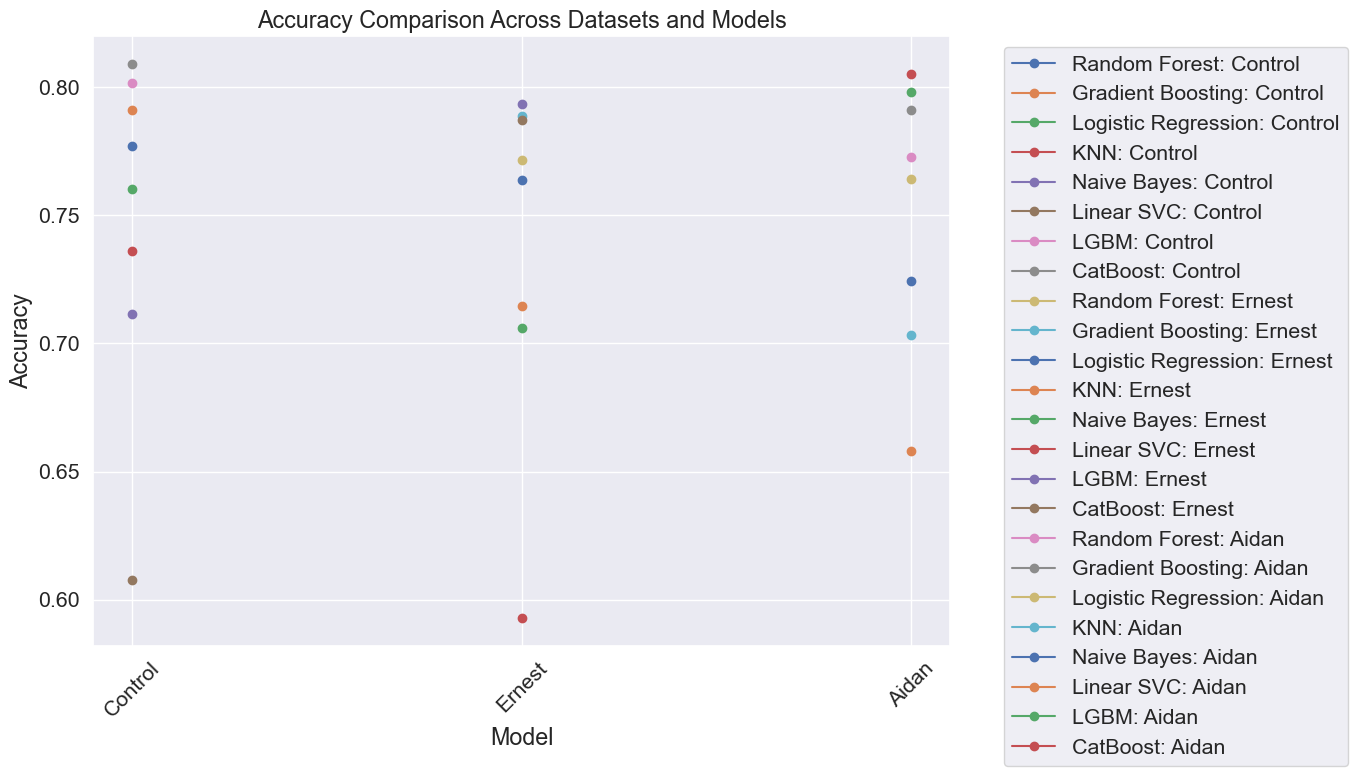

In [168]:
# Combine accuracies for all datasets
all_accuracies = {'Control': accuracies_control, 'Ernest': accuracies_ernest, 'Aidan': accuracies_aidan}

# Plot accuracies for each model on a single plot
plt.figure(figsize=(14, 8))

for model, accuracies in all_accuracies.items():
    for dataset, accuracy in accuracies.items():
        plt.plot(model, accuracy, marker='o', label=f"{dataset}: {model}")

plt.title('Accuracy Comparison Across Datasets and Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend to the right
plt.grid(True)
plt.tight_layout()
plt.show()


# Submission

In [169]:
XControl_test, YControl_test = FeatureAndTarget(test_dfControl)
XAidan_test, YAidan_test = FeatureAndTarget(test_dfAidan)
XErnest_test, YErnest_test = FeatureAndTarget(test_dfErnest)


In [170]:
def convert_column_to_boolean(column):
   
    return column.apply(lambda x: x == 1)



In [171]:
# Load the model and make predictions
model = LGBMClassifier(random_state=42)
model.fit(XControl, YControl)
y_test_pred = model.predict(XControl_test)

# Convert predictions to boolean values
y_test_pred_boolean = y_test_pred == 1

# Create the output DataFrame with PassengerId and Transported columns
output = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],  # Assuming PassengerId column is in test_dfErnest
    'Transported': y_test_pred_boolean  # Convert boolean values to integers
})

# Save the output to a CSV file
output.to_csv('output/submission.csv', index=False)
print('Submission Saved')

# Check the length of the output DataFrame
print(len(output))  # Should match the number of rows in test_dfErnest



[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495
Submission Saved
4277


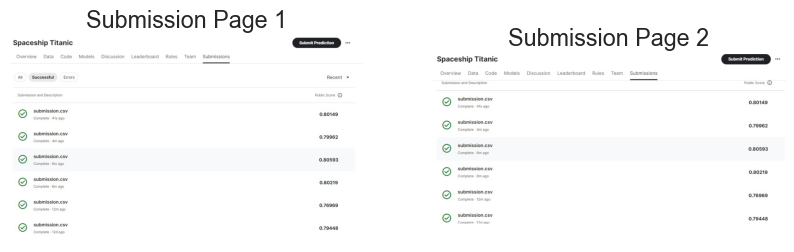

In [172]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load images
img1 = mpimg.imread('SubmissionPage1.jpeg')
img2 = mpimg.imread('SubmissionPage2.jpeg')

# Plot the images
plt.figure(figsize=(10, 5))

# Plot Image 1
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Submission Page 1')

# Plot Image 2
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Submission Page 2')

plt.show()


# 6. Analysis of the Basic Models

Interestingly, Catboost, coupled with not the intensely studied dfErnest, nor dfAidan with its expansive feature engineering, but with the control data, with simple means and modes used for filling in null values, performed the best, on the test data in this notebook, and the dfAidan with the Catboost, performed the best in the Kaggle competition on the official test data. 

### Breakdown of each model

1. **Random Forest Classifier**: Random Forest is a versatile and widely used ensemble learning method that can handle both numerical and categorical features. It's robust to overfitting and often performs well without much tuning.

2. **XGBoost Classifier**: XGBoost is a powerful gradient boosting framework known for its speed and performance. It can handle missing values and is robust to outliers. XGBoost often achieves state-of-the-art results in machine learning competitions.

3. **Logistic Regression**: Logistic Regression is a simple and interpretable model that is well-suited for binary classification tasks like this one. It provides probability estimates and can handle both numerical and categorical features.

4. **K-Nearest Neighbors (KNN) Classifier**: KNN is a non-parametric method used for classification tasks. It's simple to understand and implement, and it doesn't make strong assumptions about the underlying data distribution.

5. **Gaussian Naive Bayes Classifier**: Naive Bayes is a probabilistic classifier based on Bayes' theorem with the "naive" assumption of independence between features. It's simple, fast, and works well with high-dimensional data.

6. **Linear Support Vector Classifier (Linear SVC)**: Linear SVC is a linear classification model that works well for binary classification tasks. It's effective when the data is linearly separable and provides good generalization performance.

7. **LightGBM Classifier**: LightGBM is a gradient boosting framework that is highly efficient and scalable. It's known for its fast training speed and high accuracy, making it suitable for large datasets.

### Model Evaluation:
Each model's performance is evaluated using accuracy, which measures the proportion of correctly classified instances out of all instances. We use a train-test split of the provided training data to train the models and validate their performance.

### Conclusion:
By employing a variety of machine learning models and carefully evaluating their performance, we aim to identify the best-performing model for predicting whether a passenger was transported to another dimension during the Spaceship Titanic's collision. This approach allows us to explore different modeling techniques and select the one that provides the highest accuracy on the test data, thus optimizing our chances of success in the Kaggle competition.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold

# Define function for applying different cross-validation (CV) methods
def apply_cv_methods(model, X_train, y_train, cv_methods=['kfold', 'shuffle_split', 'stratified_kfold']):
    results = {}
    for cv_method in cv_methods:
        if cv_method == 'kfold':
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        elif cv_method == 'shuffle_split':
            cv_scores = cross_val_score(model, X_train, y_train, cv=ShuffleSplit(n_splits=5, test_size=0.2), scoring='accuracy')
        elif cv_method == 'stratified_kfold':
            cv_scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), scoring='accuracy')
        results[cv_method] = cv_scores.mean()
    return results

# Apply BaggingClassifier
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=SEED)
bagging_results = apply_cv_methods(bagging_model, X_train, y_train)
print("Bagging Classifier Results:", bagging_results)

# Apply AdaBoostClassifier
adaboost_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=SEED)
adaboost_results = apply_cv_methods(adaboost_model, X_train, y_train)
print("AdaBoost Classifier Results:", adaboost_results)


NameError: name 'SEED' is not defined

The above code applies ensemble learning techniques, Bagging and AdaBoost, to train Decision Tree classifiers for the Kaggle Spaceship Titanic project. It also evaluates the models using different cross-validation (CV) methods to assess their performance.

### Methodology and Choices:

1. **Ensemble Learning Techniques**: 
   - **Bagging**: It combines multiple decision tree classifiers trained on different subsets of the training data. The final prediction is made by averaging the predictions of all individual classifiers, leading to improved performance and reduced variance.
   - **AdaBoost**: It sequentially trains a series of decision tree classifiers, where each subsequent classifier focuses more on the instances that were misclassified by the previous ones. This iterative approach creates a strong ensemble model by emphasizing the difficult-to-classify instances.

2. **Cross-Validation (CV) Methods**:
   - **k-fold CV**: It partitions the training data into k equal-sized folds, trains the model on k-1 folds, and evaluates it on the remaining fold. This process is repeated k times, ensuring that each data point is used for both training and testing.
   - **Shuffle Split CV**: It randomly shuffles the data and splits it into train/test sets multiple times. This method is useful when the dataset is large and doesn't require exhaustive splitting.
   - **Stratified k-fold CV**: It ensures that each fold contains approximately the same proportion of classes as the entire dataset. This is particularly useful for imbalanced datasets where one class dominates the other.

3. **Model Evaluation**:
   - The code evaluates each model's performance using accuracy scores obtained from cross-validation. Accuracy is a suitable metric for this binary classification task as it measures the proportion of correctly predicted instances out of all instances.

4. **Scikit-Learn Tools**:
   - The code utilizes scikit-learn's efficient implementations of ensemble learning algorithms, cross-validation methods, and decision tree classifiers. Scikit-learn provides a comprehensive toolkit for building, training, and evaluating machine learning models, making it a suitable choice for this project.


# Self-learning

In the journey of mastering machine learning, one of the most profound concepts we encountered is self-learning. Self-learning entails the process of continuously acquiring knowledge and skills without direct human intervention, driven solely by the data and algorithms at one's disposal.

We learnt many skills and lessons from this project, related to teamwork and ML approaches.

Regarding teamwork, our approach was quite divided, to have four different notebooks and then amalgamated them into one, with the different data cleaning, feature engineering and models separated into functions to show the different accuracies. This proved to be a challenge, because it was much easier to write the four individual notebooks, and it was unexpectedly difficult to amalgamate them. We learnt that it is better to approach a group project in ML with a group mentality from the start.

Regarding the actual data cleaning and feature engineering, Occam's razor comes into light, because the simple data preparation performed better than the complicated preparation[1]. In complex models, simple data preparation and engineering may often produce better results for ML models, which was an interesting discovery.

## Experience with different models: 

### Random Forest
- **Pros:**
  - Effective for large datasets with high dimensionality.
  - Handles missing values well.
  - Reduces overfitting by averaging multiple decision trees.
- **Cons:**
  - Can be slow to train on very large datasets.
  - Not easily interpretable compared to simpler models.

### Gradient Boosting
- **Pros:**
  - Often yields high predictive accuracy.
  - Handles different types of data well.
  - Reduces bias and variance through boosting.
- **Cons:**
  - Can be prone to overfitting if not properly tuned.
  - Requires careful hyperparameter tuning.

### Logistic Regression
- **Pros:**
  - Simple and interpretable.
  - Efficient for small datasets.
  - Outputs probabilities.
- **Cons:**
  - Assumes linear relationship between features and target.
  - Limited expressive power compared to more complex models.

### K-Nearest Neighbors (KNN)
- **Pros:**
  - Simple and easy to understand.
  - No training time.
  - Works well with small datasets and noisy data.
- **Cons:**
  - Computationally expensive during prediction, especially with large datasets.
  - Sensitive to irrelevant or redundant features.
  
### Naive Bayes
- **Pros:**
  - Fast and simple.
  - Performs well with high-dimensional data.
  - Handles missing values well.
- **Cons:**
  - Assumes independence between features, which may not always hold true.
  - Can be overly simplistic for some datasets.

### Linear Support Vector Classifier (Linear SVC)
- **Pros:**
  - Effective in high-dimensional spaces.
  - Memory efficient.
  - Versatile, can use different kernels for non-linear decision boundaries.
- **Cons:**
  - Not suitable for large datasets as training time can be slow.
  - Sensitivity to feature scaling.

### LightGBM
- **Pros:**
  - Fast and efficient, particularly with large datasets.
  - High accuracy with less overfitting.
  - Supports categorical features directly.
- **Cons:**
  - Requires careful parameter tuning.
  - May not perform as well on smaller datasets.

### CatBoost
- **Pros:**
  - Handles categorical features naturally.
  - Robust to overfitting.
  - Automatically handles missing data.
- **Cons:**
  - Slower training compared to other gradient boosting implementations.
  - Requires more memory during training.




## Function: hyperparameter_tuning

This function performs hyperparameter tuning for a given model using either GridSearchCV or RandomizedSearchCV from scikit-learn.

### Parameters:
- `model`: Scikit-learn estimator object.
- `param_grid` (dict): Dictionary with hyperparameter names as keys and lists of hyperparameter values to try.
- `X_train` (array-like): Feature matrix of training data.
- `y_train` (array-like): Target vector of training data.
- `cv` (int, cross-validation generator, or an iterable): Determines the cross-validation splitting strategy. Default is 5-fold cross-validation.
- `search_type` (str): Type of hyperparameter search, either 'grid' for GridSearchCV or 'random' for RandomizedSearchCV. Default is 'grid'.

### Returns:
- `best_estimator`: Fitted model with the best hyperparameters found during the search.

### Example Usage:
```python
from sklearn.svm import SVC

# Define parameter grid for SVC
svc_param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01], 'kernel': ['linear', 'rbf']}

# Perform hyperparameter tuning for SVC
best_svc = hyperparameter_tuning(SVC(), svc_param_grid, X_train, y_train)


In [ ]:
def hyperparameter_tuning(model, param_grid, X_train, y_train, cv=5, search_type='grid'): 
    if search_type == 'grid':
        search = GridSearchCV(model, param_grid, cv=cv, verbose=2, n_jobs=-1)
    elif search_type == 'random':
        search = RandomizedSearchCV(model, param_grid, cv=cv, verbose=2, n_jobs=-1)
    else:
        raise ValueError("Invalid search_type. Choose either 'grid' or 'random'.")

    search.fit(X_train, y_train)
    best_estimator = search.best_estimator_
    
    return best_estimator

## Application of the hyperparameter_tuning function

In [ ]:
#1. Random Forest
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

# Apply hyperparameter tuning
best_rf_model = hyperparameter_tuning(rf_model, rf_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_rf_model.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy after Hyperparameter Tuning:", rf_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#2. Linear SVC

# Define the parameter grid for Linear SVC
param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Apply hyperparameter tuning
best_linear_svc = hyperparameter_tuning(LinearSVC(), param_grid_svc, X_train, y_train, search_type='random')

# Fit the best model on the training data
best_linear_svc.fit(X_train, y_train)

# Predict on the test data
y_pred_svc = best_linear_svc.predict(X_test)

# Calculate accuracy
svc_accuracy = accuracy_score(y_test, y_pred_svc)

print("Linear SVC Accuracy after Hyperparameter Tuning:", svc_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#3.For LGBMClassifier
# Define the parameter grid for LGBMClassifier
param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [20, 30, 40],
    'n_estimators': [50, 100, 200]
}

# Apply hyperparameter tuning
best_lgbm_model = hyperparameter_tuning(LGBMClassifier(random_state=42), param_grid_lgbm, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_lgbm_model.fit(X_train, y_train)

# Predict on the test data
y_pred_lgbm = best_lgbm_model.predict(X_test)

# Calculate accuracy
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
print("LGBMClassifier Accuracy after Hyperparameter Tuning:", lgbm_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#4.For Pipeline:
# Define parameter grid
param_grid_svc = {
    "model__C": [0.001, 0.01, 0.1, 1, 10],
    "model__gamma": ["scale", "auto"],
    "model__kernel": ["rbf"]
}

# Perform hyperparameter tuning with your function
best_pipe6 = hyperparameter_tuning(pipe6, param_grid_svc, X_train, y_train, cv=5, search_type='random')


# Evaluate the best estimator
pipe6_accuracy = best_pipe6.score(X_test, y_test)
print("PipeLine Accuracy after Hyperparameter Tuning:", pipe6_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#5.For Logistic Regression:
# Define the parameter grid for Logistic Regression
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Apply hyperparameter tuning
best_logreg_model = hyperparameter_tuning(logreg_model, logreg_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_logreg_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_logreg_model.predict(X_test)

# Calculate accuracy
logreg_accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy after Hyperparameter Tuning:", logreg_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#6.For XGBoost:

# Define the parameter grid for XGBoost Classifier
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Apply hyperparameter tuning
best_xgb_model = hyperparameter_tuning(xgb_model, xgb_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_xgb_model.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Classifier Accuracy after Hyperparameter Tuning:", xgb_accuracy)
#----------------------------------------------------------------------------------------------------------------------------
#7.For KNN:

# Define the parameter grid for KNN Classifier
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # For Minkowski distance (1 for Manhattan, 2 for Euclidean)
}

# Apply hyperparameter tuning
best_knn_model = hyperparameter_tuning(knn_model, knn_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_knn_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_knn_model.predict(X_test)

# Calculate accuracy
knn_accuracy = accuracy_score(y_test, y_pred)
print("KNN Classifier Accuracy after Hyperparameter Tuning:", knn_accuracy)
#----------------------------------------------------------------------------------------------------------------------------
#8.For Gaussian Naive Bayes
#Since NB doesn't have hyperparameters to tune, you don't need to perform hyperparameter tuning.
#Instead, you can directly evaluate its performance using cross-validation.

# Perform cross-validation
nb_scores = cross_val_score(nb_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation Scores:", nb_scores)

# Calculate and print the mean accuracy
nb_mean_accuracy = nb_scores.mean()
print("Mean Accuracy:", nb_mean_accuracy)

NameError: name 'rf_model' is not defined

# References
[1] Bargagli Stoffi, F.J., Cevolani, G. and Gnecco, G., 2022. Simple models in complex worlds: Occam’s razor and statistical learning theory. Minds and Machines, 32(1), pp.13-42.

[2] Simon, P., 2014. The visual organization: Data visualization, big data, and the quest for better decisions. John Wiley & Sons.

[3] Cortinas, S., 2022. "Spaceship Titanic: A complete guide.", kaggle.com https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide (Accessed Mar. 5, 2024)

[4] Das, D., "Combating High Cardinality Features in Supervised Machine Learning", THIRDEYE, thirdeyedata.ai https://thirdeyedata.ai/combating-high-cardinality-features-in-supervised-machine-learning/ (Accessed Mar 24, 2024)

[5] SavourSauce. *Spaceship Titanic, Full Competition Tutorial*. (Sep 25, 2023). Accessed: Feb 28, 2024. [Online video]. Available: https://www.youtube.com/watch?v=Tm70lEXivCg&t=210s 

